## Imports

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import textwrap
from scipy import stats
from multiprocessing import Pool, cpu_count
from functools import partial

# Import custom modules
import data_utils
import analysis
import plotting

%matplotlib inline

## Configuration

In [2]:
DATA_DIR = "data"

# Create main plots directory structure
PLOTS_BASE_DIR = "plots"
os.makedirs(PLOTS_BASE_DIR, exist_ok=True)

# Subdirectories for different plot types
SCATTERS_DIR = os.path.join(PLOTS_BASE_DIR, "scatters")
REGSCATTERS_DIR = os.path.join(PLOTS_BASE_DIR, "regscatters")
IE_SCATTERS_DIR = os.path.join(PLOTS_BASE_DIR, "IE-scatters")
IE_REGSCATTERS_DIR = os.path.join(PLOTS_BASE_DIR, "IE-regscatters")
NOIE_SCATTERS_DIR = os.path.join(PLOTS_BASE_DIR, "noIE-scatters")
NOIE_REGSCATTERS_DIR = os.path.join(PLOTS_BASE_DIR, "noIE-regscatters")
HEADINIT_SCATTERS_DIR = os.path.join(PLOTS_BASE_DIR, "headInit-scatters")
HEADINIT_REGSCATTERS_DIR = os.path.join(PLOTS_BASE_DIR, "headInit-regscatters")
HEADFINAL_SCATTERS_DIR = os.path.join(PLOTS_BASE_DIR, "headFinal-scatters")
HEADFINAL_REGSCATTERS_DIR = os.path.join(PLOTS_BASE_DIR, "headFinal-regscatters")
FACTORHISTOGRAMS_DIR = os.path.join(PLOTS_BASE_DIR, "factorhistograms")
IE_FACTORHISTOGRAMS_DIR = os.path.join(PLOTS_BASE_DIR, "IE-factorhistograms")
NOIE_FACTORHISTOGRAMS_DIR = os.path.join(PLOTS_BASE_DIR, "noIE-factorhistograms")
HEADINIT_FACTORHISTOGRAMS_DIR = os.path.join(PLOTS_BASE_DIR, "headInit-factorhistograms")
HEADFINAL_FACTORHISTOGRAMS_DIR = os.path.join(PLOTS_BASE_DIR, "headFinal-factorhistograms")

# Create all directories
for dir_path in [SCATTERS_DIR, REGSCATTERS_DIR, IE_SCATTERS_DIR, IE_REGSCATTERS_DIR, 
                 NOIE_SCATTERS_DIR, NOIE_REGSCATTERS_DIR, HEADINIT_SCATTERS_DIR, HEADINIT_REGSCATTERS_DIR,
                 HEADFINAL_SCATTERS_DIR, HEADFINAL_REGSCATTERS_DIR, FACTORHISTOGRAMS_DIR,
                 IE_FACTORHISTOGRAMS_DIR, NOIE_FACTORHISTOGRAMS_DIR, HEADINIT_FACTORHISTOGRAMS_DIR,
                 HEADFINAL_FACTORHISTOGRAMS_DIR]:
    os.makedirs(dir_path, exist_ok=True)

plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 11

print(f"Created plot directory structure under: {PLOTS_BASE_DIR}")

Created plot directory structure under: plots


## 1. Load Data

In [3]:
# Load metadata
metadata = data_utils.load_metadata(os.path.join(DATA_DIR, 'metadata.pkl'))

langNames = metadata['langNames']
langnameGroup = metadata['langnameGroup']
group2lang = metadata['group2lang']
appearance_dict = metadata['appearance_dict']

print(f"Languages: {len(langNames)}")
print(f"Groups: {len(set(langnameGroup.values()))}")

Loaded metadata from data/metadata.pkl
Languages: 186
Groups: 11


In [4]:
# Load analysis results
results = analysis.load_analysis_results(DATA_DIR)

all_langs_position2num = results['all_langs_position2num']
all_langs_position2sizes = results['all_langs_position2sizes']
all_langs_average_sizes = results['all_langs_average_sizes']
filtered_position2num = results['filtered_position2num']
filtered_position2sizes = results['filtered_position2sizes']
lang2MAL = results['lang2MAL']

# Use filtered data for plotting
all_langs_average_sizes_filtered = all_langs_average_sizes

print(f"Languages with results: {len(all_langs_average_sizes)}")

Loaded all_langs_position2num.pkl
Loaded all_langs_position2sizes.pkl
Loaded all_langs_average_sizes.pkl
Loaded filtered_position2num.pkl
Loaded filtered_position2sizes.pkl
Loaded lang2MAL.pkl
All analysis results loaded from data/
Languages with results: 186


## 2. Create Color Palettes

Create color palettes for:
- Language groups (all languages)
- Indo-European genera (IE languages only)

In [5]:
# Group-level color palette (already in appearance_dict)
group_to_color = appearance_dict
print(f"Language groups with colors: {len(group_to_color)}")
print("Sample:", list(group_to_color.items())[:5])

Language groups with colors: 29
Sample: [('Italic', 'brown'), ('Baltoslavic', 'purple'), ('Germanic', 'olive'), ('Indo-European', 'royalBlue'), ('Austronesian', 'limeGreen')]


In [6]:
# Create Indo-European genus color palette
# First, identify IE languages and their genera
# This requires loading the language_to_group sheet which has genus information
sheets_data = data_utils.load_google_sheets(
    metadata.get('credentials_file', 'typometrics-c4750cac2e21.json'),
    metadata.get('spreadsheet_url', 'https://docs.google.com/spreadsheets/d/1IP3ebsNNVAsQ5sxmBnfEAmZc4f0iotAL9hd4aqOOcEg/edit')
)

language_to_group_df = sheets_data['dataframes']['language_to_group']
langnameGenus = language_to_group_df.set_index('Language').to_dict()['Genus']

# Filter to only IE languages
IElangnameGenus = {
    lang: langnameGenus[lang] 
    for lang in langnameGroup 
    if langnameGroup[lang] == 'Indo-European' and lang in langnameGenus
}

# Create color palette for IE genera
ie_genera = sorted(set(IElangnameGenus.values()))
ie_palette = sns.color_palette("husl", len(ie_genera))
IEgenus_to_color = dict(zip(ie_genera, ie_palette))

print(f"IE genera: {len(ie_genera)}")
print("Sample:", list(IEgenus_to_color.keys())[:5])

IE genera: 9
Sample: ['', 'Baltoslavic', 'Celtic', 'Germanic', 'Hellenic']


## 3. Define Helper Functions

The main plotting function `plot_dependency_sizes` is now in the `plotting` module.

In [7]:
def _plot_task(args):
    """Helper function for parallel plotting."""
    (pos1_str, pos2_str, prefix, all_langs_average_sizes_filtered, 
     filter_lang, langNames, langnameGroup, langname_group_or_genus, 
     folderprefix, palette) = args
    
    plotting.plot_dependency_sizes(
        pos1_str, 
        pos2_str, 
        prefix,
        all_langs_average_sizes_filtered,  
        filter_lang=filter_lang,
        langNames=langNames,
        langnameGroup=langnameGroup,
        langname_group_or_genus=langname_group_or_genus,               
        folderprefix=folderprefix, 
        palette=palette,
        show_inline=False  # Don't show inline for batch processing
    )
    return f"{prefix}: {pos1_str} vs {pos2_str}"


def plot_all(filter_lang, langname_group_or_genus=None, folderprefix='', palette=None, parallel=True):
    """
    Plot all dependency size comparisons.
    
    Parameters
    ----------
    filter_lang : function
        Function to filter languages
    langname_group_or_genus : dict
        Mapping of language names to groups or genera
    folderprefix : str
        Prefix for output folders
    palette : dict
        Color palette
    parallel : bool
        Whether to use parallel processing (default True)
    """
    if langname_group_or_genus is None:
        langname_group_or_genus = langnameGroup
    if palette is None:
        palette = group_to_color
    
    print(f'_________________________ plotting all ___________________________ {folderprefix}')
    
    measures = [
        ('MAL', 'right_{k}_totright_{m}', 'right_{k}_totright_{n}', [1,5], [1,5]), # MAL comparison
        ('MAL', 'left_{k}_totleft_{m}', 'left_{k}_totleft_{n}', [1,5], [1,5]), # MAL left side
        ('HCS', 'right_{j}_totright_{n}', 'right_{k}_totright_{n}', [2,6], [2,6]), # HCS comparison
        ('HCS', 'left_{j}_totleft_{n}', 'left_{k}_totleft_{n}', [2,6], [2,6]), # HCS left side - j < k, so j on x-axis
        ('DIAG', 'right_{k}_totright_{n}', 'right_{l}_totright_{m}', [1,5], [1,5]), # Diagonal comparison
        ('DIAG', 'left_{k}_totleft_{n}', 'left_{l}_totleft_{m}', [1,5], [1,5]), # Diagonal left side
    ]
    
    # Build list of all plot tasks
    tasks = []
    for (prefix, pos1, pos2, n_range, k_range) in measures:
        for n in range(*n_range):
            for k in range(*k_range):
                if k <= n:
                    m = n + 1
                    j = k - 1
                    l = k + 1
                    pos1_str = pos1.format(n=n, k=k, m=m, j=j, l=l)
                    pos2_str = pos2.format(n=n, k=k, m=m, j=j, l=l)
                    
                    tasks.append((
                        pos1_str, pos2_str, prefix, all_langs_average_sizes_filtered,
                        filter_lang, langNames, langnameGroup, langname_group_or_genus,
                        folderprefix, palette
                    ))
    
    print(f"Total plots to generate: {len(tasks)}")
    
    if parallel:
        # Use multiprocessing for parallel execution
        num_cores = cpu_count()
        print(f"Using {num_cores} CPU cores for parallel processing")
        
        with Pool(processes=num_cores) as pool:
            results = pool.map(_plot_task, tasks)
        
        print(f"\n✅ Completed {len(results)} plots")
    else:
        # Sequential execution (original behavior)
        for task in tasks:
            result = _plot_task(task)
            print(result)

In [8]:
def _plot_factor_task(args):
    """Helper function for parallel factor plotting."""
    return plotting.plot_hcs_factor(*args)


def plot_all_factors(all_langs_average_sizes_filtered, langNames, langnameGroup, 
                      group_to_color, output_folder='plots/factorhistograms', 
                      filter_lang=None, parallel=True):
    """
    Compute and plot HCS factors for all interesting neighboring comparisons.
    
    Parameters
    ----------
    all_langs_average_sizes_filtered : dict
        Dictionary of language data
    langNames : dict
        Language code to name mapping
    langnameGroup : dict
        Language name to group mapping
    group_to_color : dict
        Group to color mapping
    output_folder : str
        Output folder for plots (default: 'plots/factorhistograms')
    filter_lang : function, optional
        Function to filter languages (returns True/False)
    parallel : bool
        Whether to use parallel processing
    """
    print(f'_________________________ Computing HCS factors ___________________________')
    
    measures = [
        ('MAL', 'right_{k}_totright_{m}', 'right_{k}_totright_{n}', [1,5], [1,5]),
        ('MAL', 'left_{k}_totleft_{m}', 'left_{k}_totleft_{n}', [1,5], [1,5]),
        ('HCS', 'right_{j}_totright_{n}', 'right_{k}_totright_{n}', [2,6], [2,6]),
        ('HCS', 'left_{j}_totleft_{n}', 'left_{k}_totleft_{n}', [2,6], [2,6]),
        ('DIAG', 'right_{k}_totright_{n}', 'right_{l}_totright_{m}', [1,5], [1,5]),
        ('DIAG', 'left_{k}_totleft_{n}', 'left_{l}_totleft_{m}', [1,5], [1,5]),
    ]
    
    # Build list of all factor computation tasks
    tasks = []
    for (prefix, pos1, pos2, n_range, k_range) in measures:
        for n in range(*n_range):
            for k in range(*k_range):
                if k <= n:
                    m = n + 1
                    j = k - 1
                    l = k + 1
                    pos1_str = pos1.format(n=n, k=k, m=m, j=j, l=l)
                    pos2_str = pos2.format(n=n, k=k, m=m, j=j, l=l)
                    
                    tasks.append((
                        pos1_str, pos2_str, prefix, all_langs_average_sizes_filtered,
                        langNames, langnameGroup, group_to_color, output_folder, filter_lang
                    ))
    
    print(f"Total factor plots to generate: {len(tasks)}")
    
    if parallel:
        # Use multiprocessing for parallel execution
        num_cores = cpu_count()
        print(f"Using {num_cores} CPU cores for parallel processing")
        
        with Pool(processes=num_cores) as pool:
            results = pool.map(_plot_factor_task, tasks)
        
        print(f"\n✅ Completed {len(results)} factor plots")
        # Print sample results
        for result in results[:5]:
            if result:
                print(f"  {result}")
        if len(results) > 5:
            print(f"  ... and {len(results) - 5} more")
    else:
        # Sequential execution
        results = []
        for task in tasks:
            result = _plot_factor_task(task)
            results.append(result)
            if result:
                print(result)
    
    return results

## 4. Test Plots with Sample Comparisons

Before generating all plots, test the plotting functions with a few sample comparisons to verify the output.

In [9]:
# Define filter functions for testing
def filter_lang_all(lang):
    """Include all languages."""
    return True


Testing left side: left_1 vs left_2
✓ Saved plot: plots/scatters/TEST_LEFT_left_1_vs_left_2.png
✓ Saved plot: plots/scatters/TEST_LEFT_left_1_vs_left_2.png


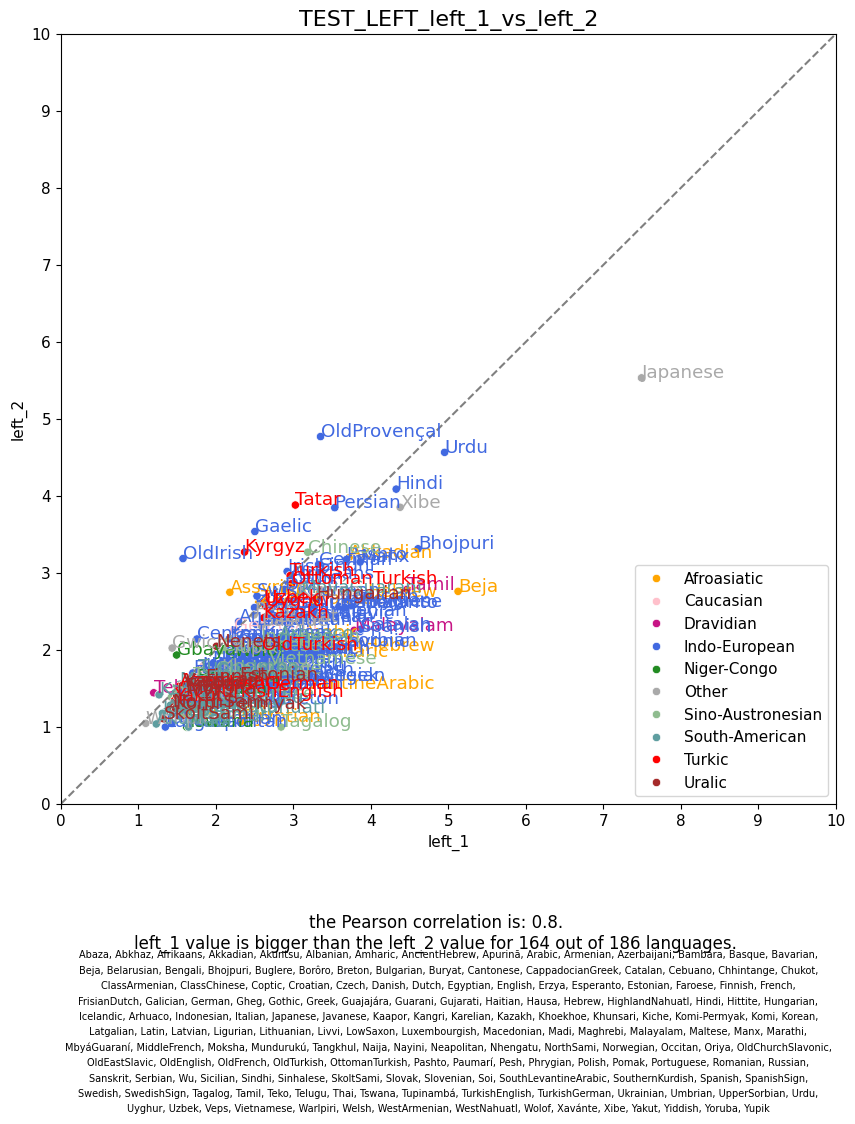

✓ Saved regression plot: plots/regscatters/TEST_LEFT_left_1_vs_left_2 regplot.png


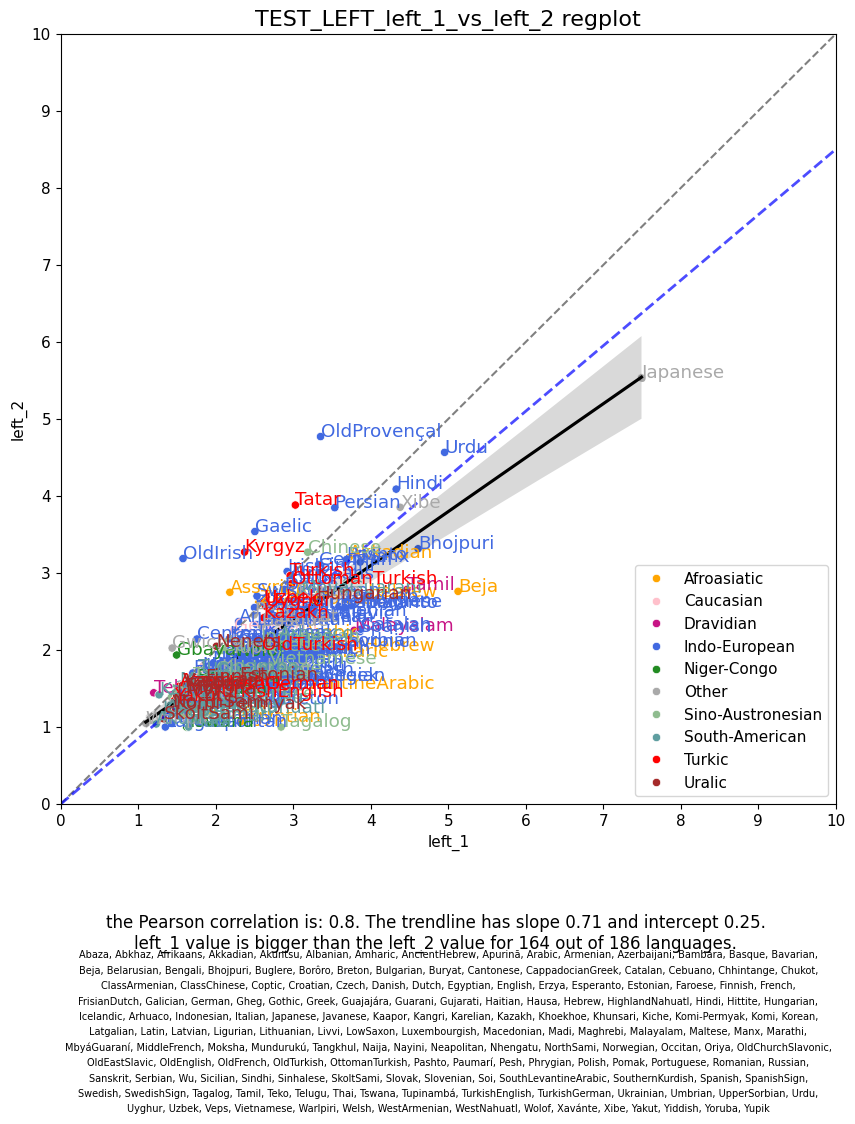

In [10]:
# Test left side comparison
print("\nTesting left side: left_1 vs left_2")
plotting.plot_dependency_sizes(
    'left_1', 
    'left_2', 
    'TEST_LEFT',
    all_langs_average_sizes_filtered,  
    filter_lang=filter_lang_all,
    langNames=langNames,
    langnameGroup=langnameGroup,
    langname_group_or_genus=langnameGroup,               
    folderprefix='', 

    palette=group_to_color)


Testing MAL comparison: right_1_totright_2 vs right_1_totright_1
✓ Saved plot: plots/scatters/TEST_MAL_right_1_totright_2_vs_right_1_totright_1.png
✓ Saved plot: plots/scatters/TEST_MAL_right_1_totright_2_vs_right_1_totright_1.png


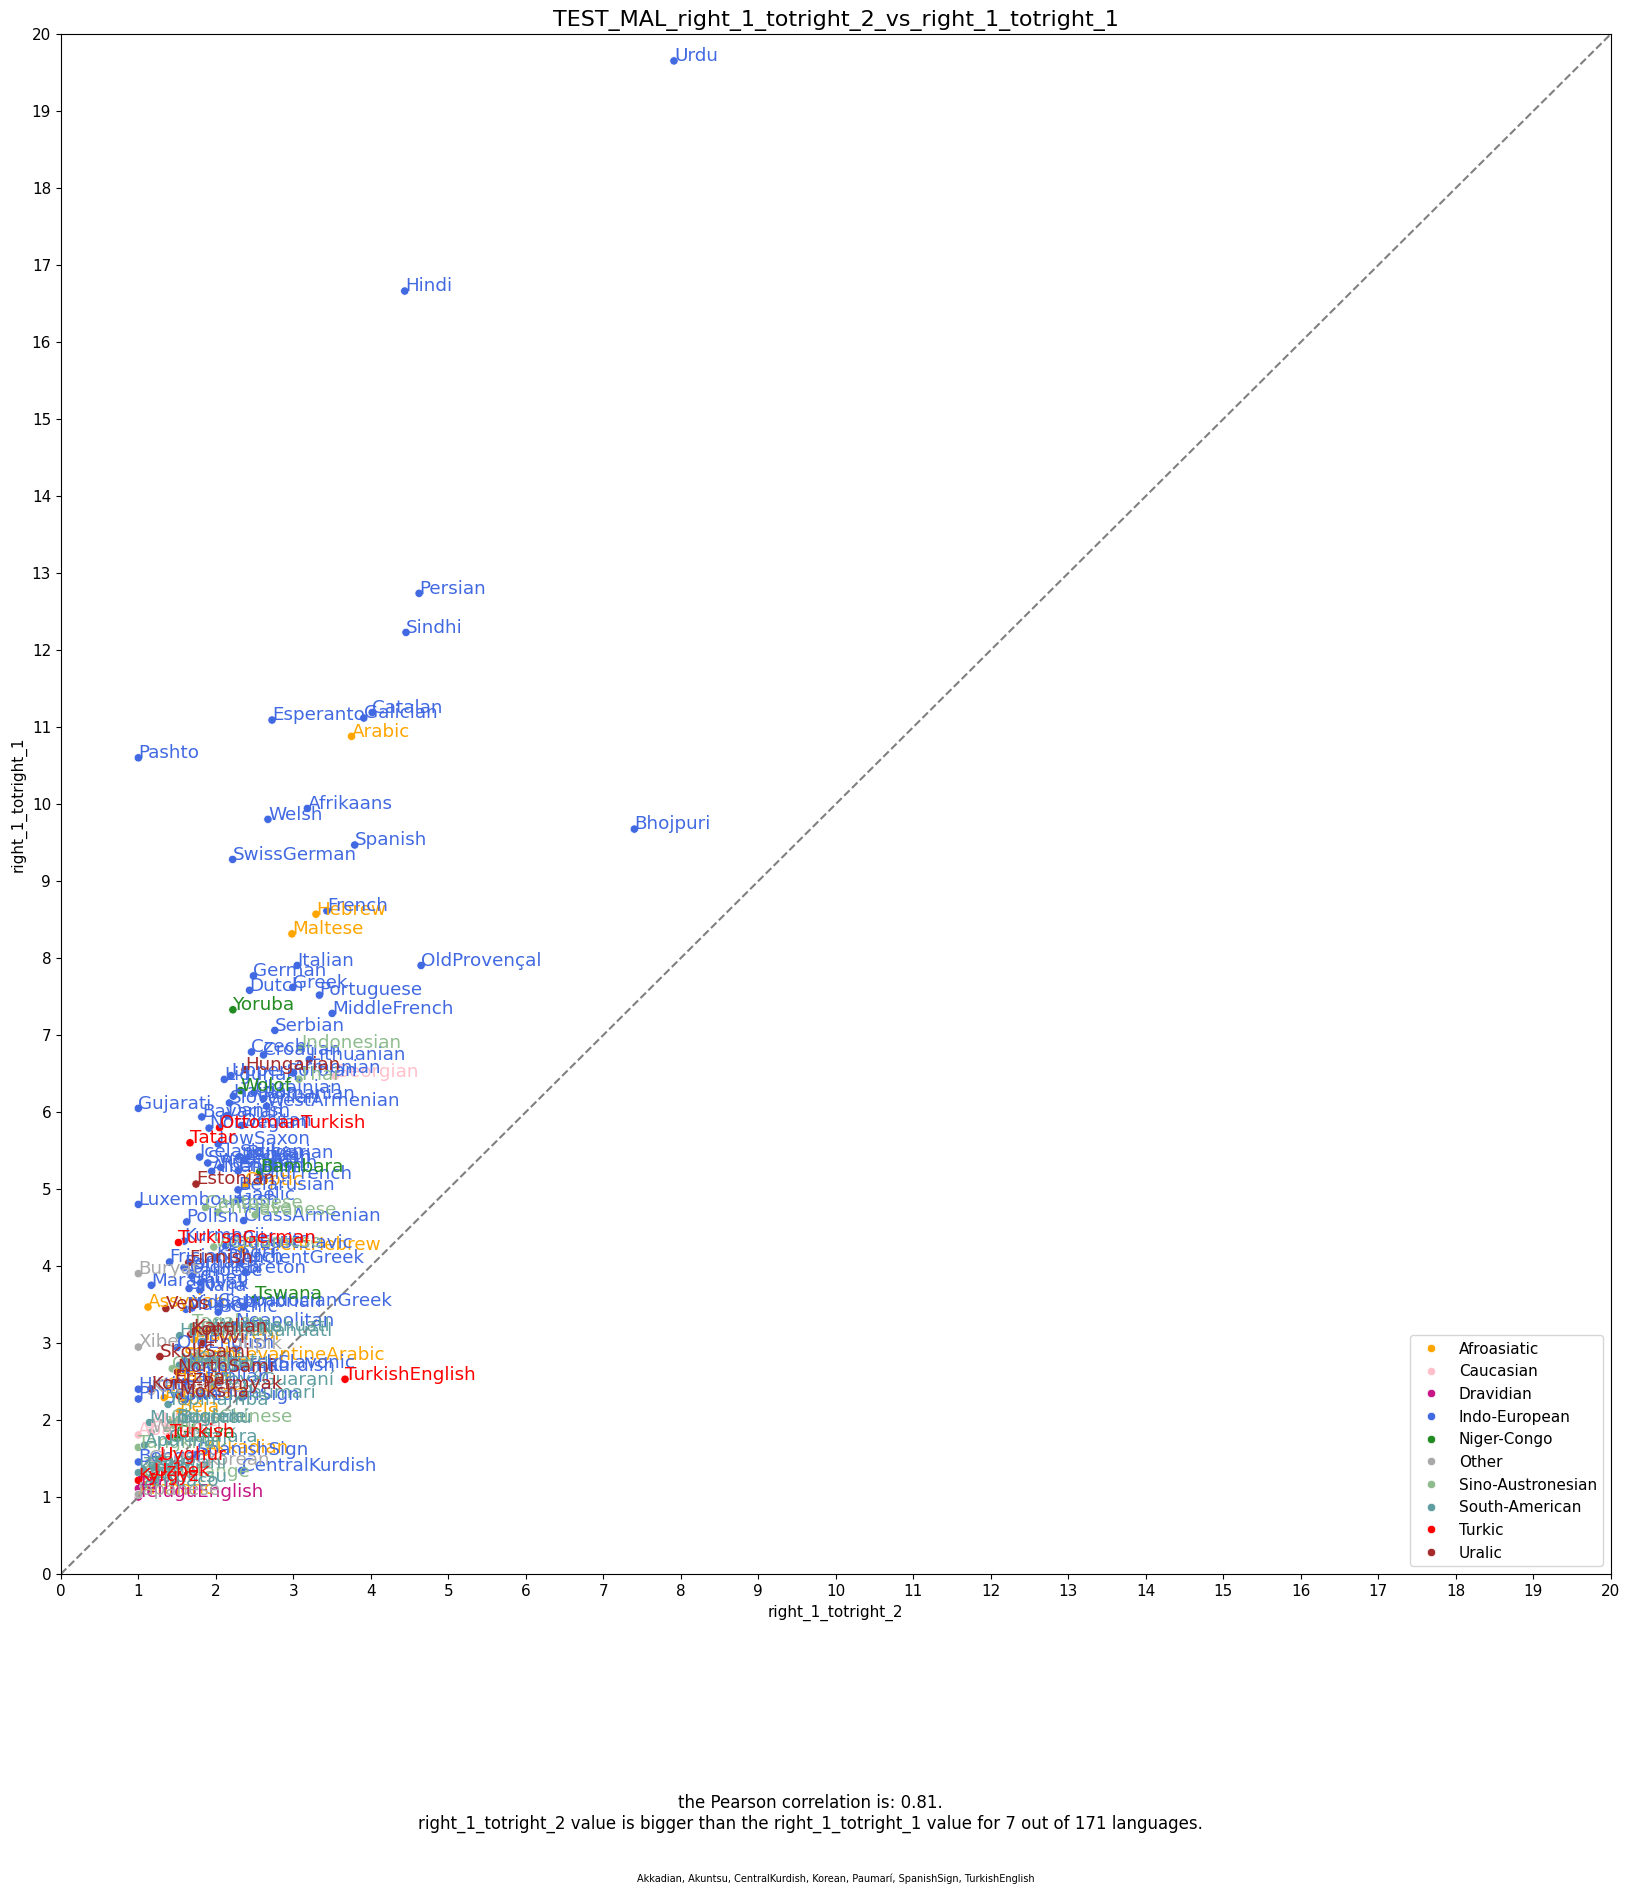

✓ Saved regression plot: plots/regscatters/TEST_MAL_right_1_totright_2_vs_right_1_totright_1 regplot.png


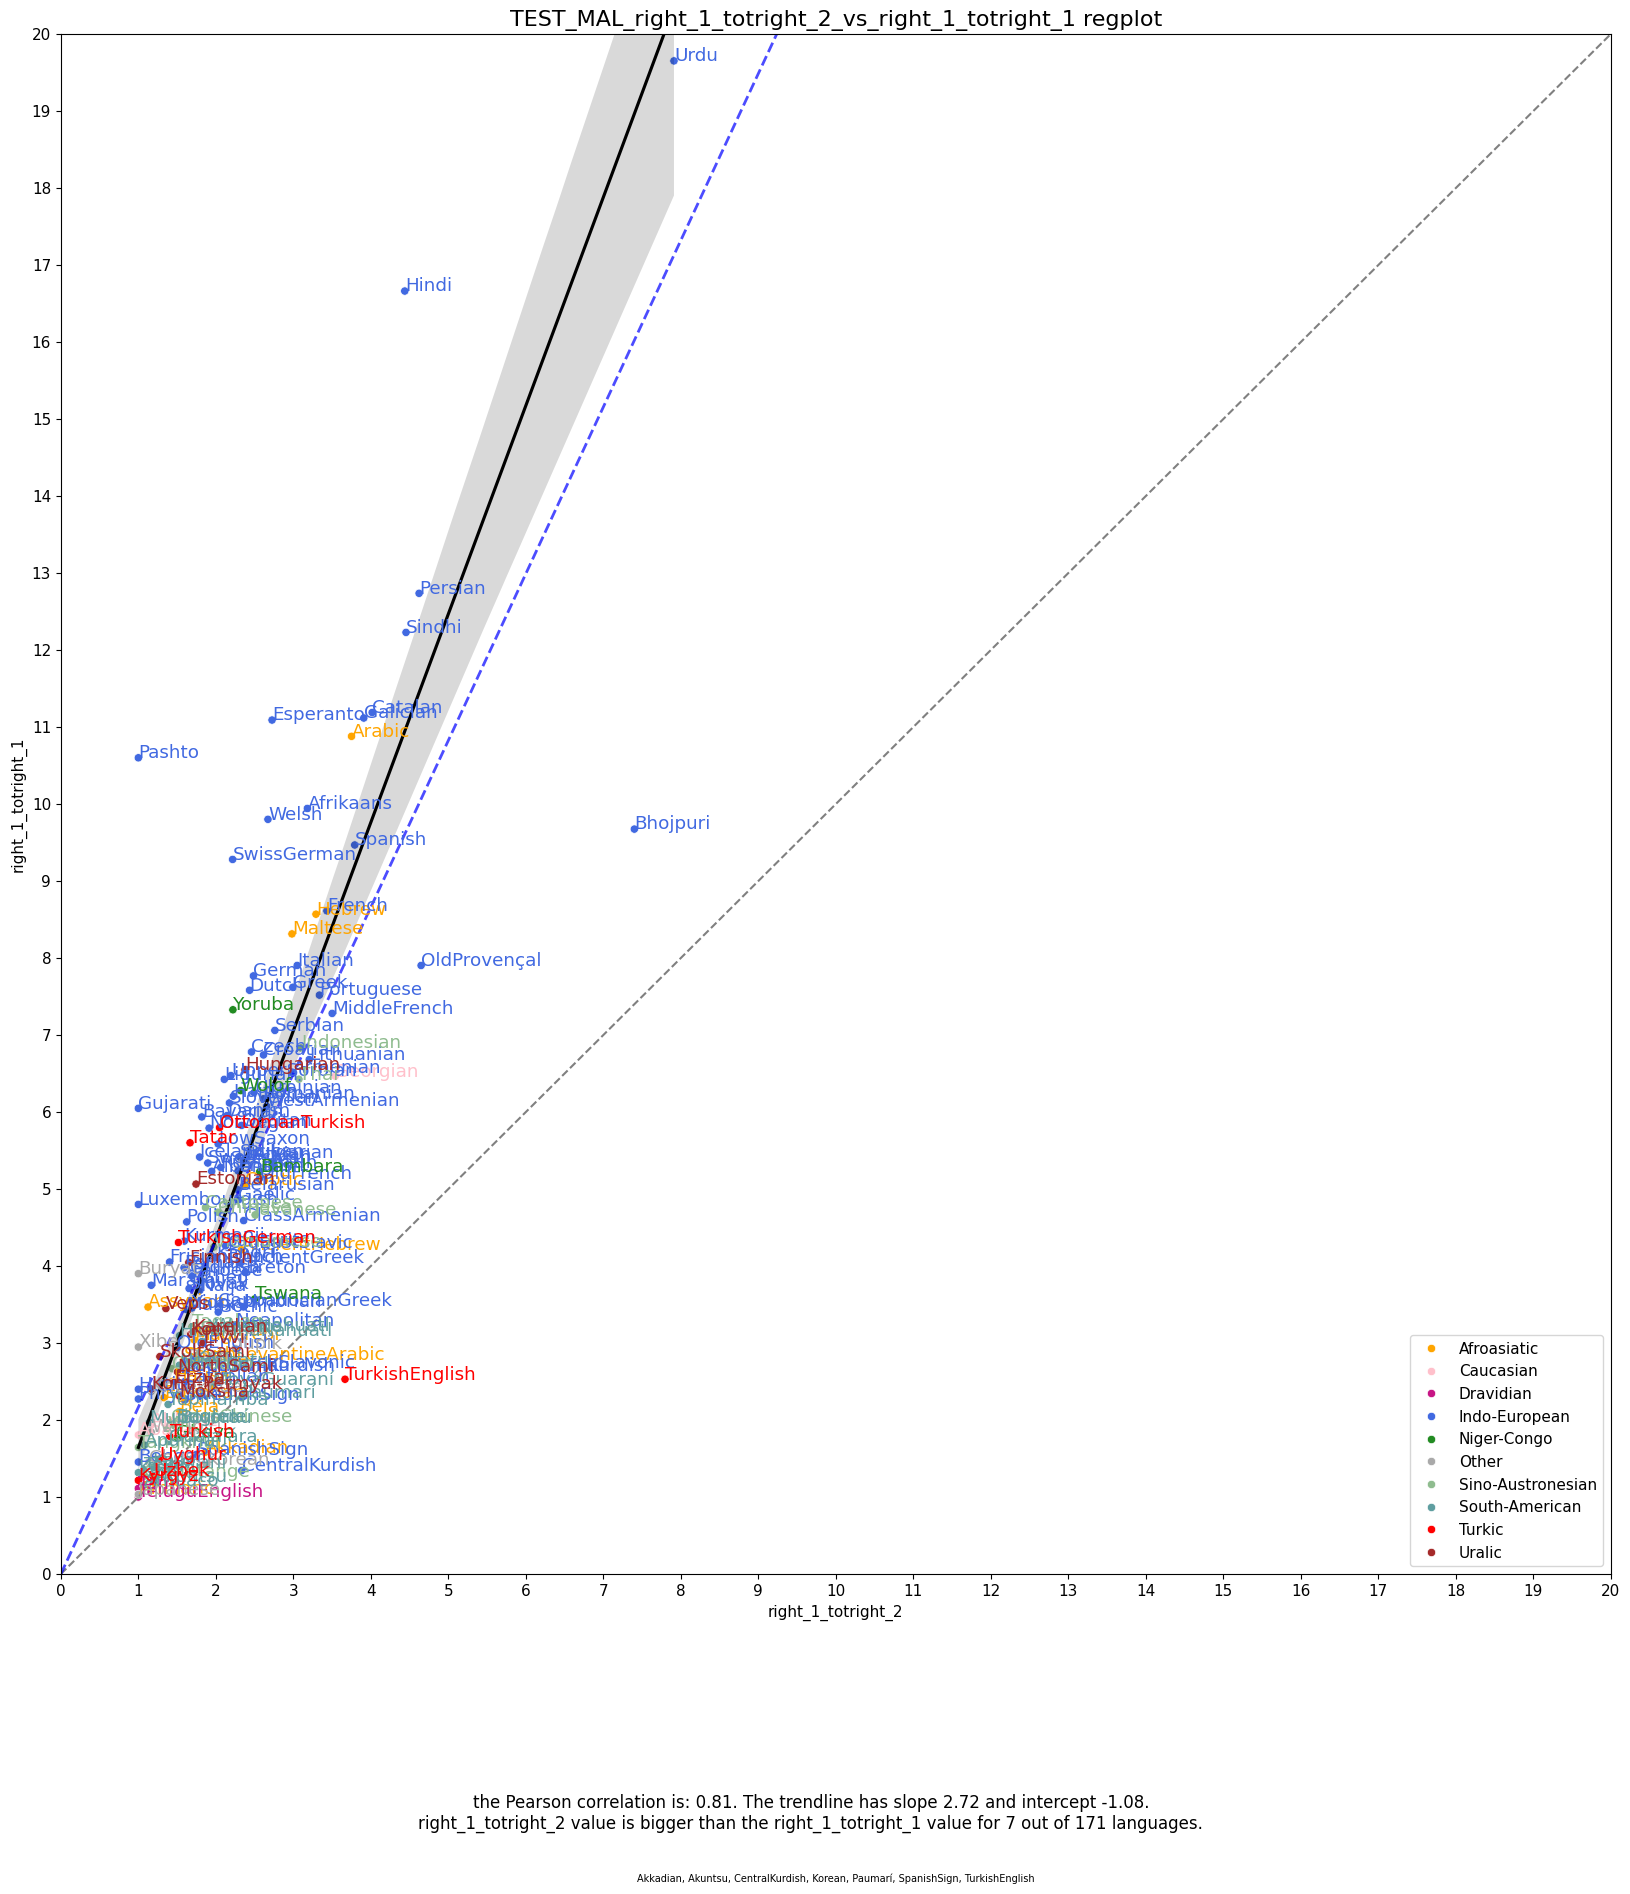

In [11]:
# Test MAL comparison: right_1_totright_2 vs right_1_totright_1
print("\nTesting MAL comparison: right_1_totright_2 vs right_1_totright_1")
plotting.plot_dependency_sizes(
    'right_1_totright_2', 
    'right_1_totright_1', 
    'TEST_MAL',
    all_langs_average_sizes_filtered,  
    filter_lang=filter_lang_all,
    langNames=langNames,
    langnameGroup=langnameGroup,
    langname_group_or_genus=langnameGroup,               
    folderprefix='', 

    palette=group_to_color)

Testing plot_dependency_sizes with right_1 vs right_2
✓ Saved plot: plots/scatters/TEST_right_1_vs_right_2.png
✓ Saved plot: plots/scatters/TEST_right_1_vs_right_2.png


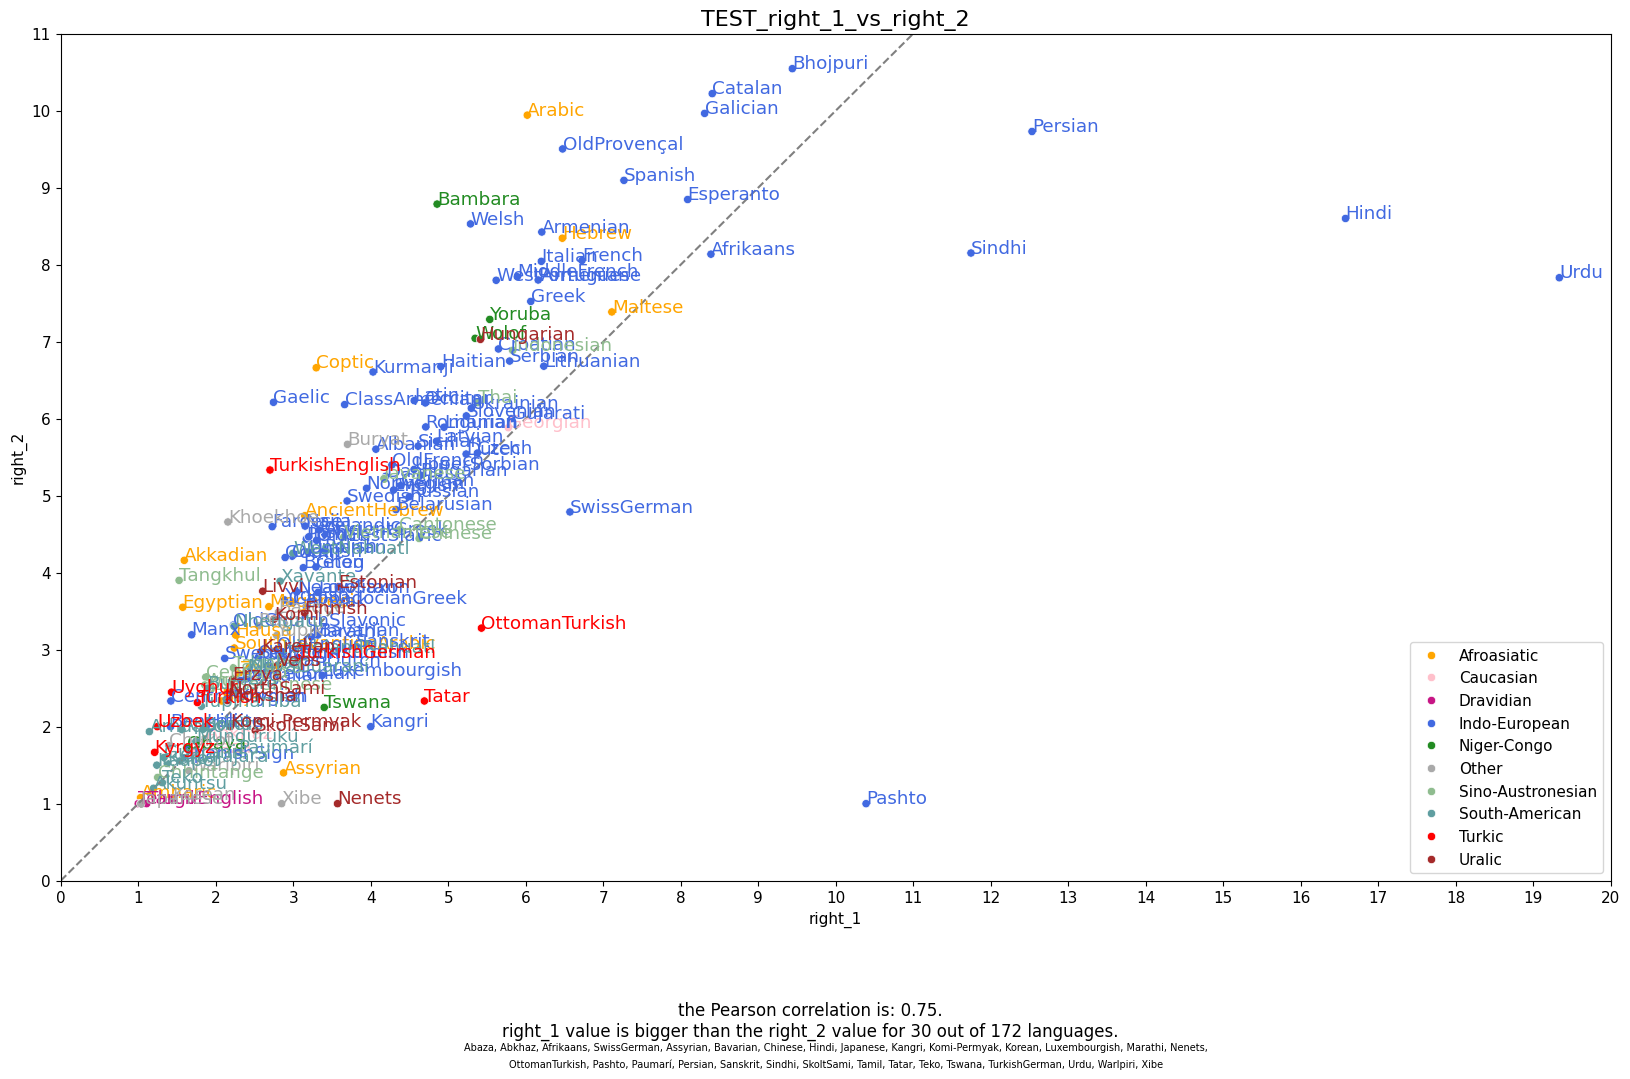

✓ Saved regression plot: plots/regscatters/TEST_right_1_vs_right_2 regplot.png


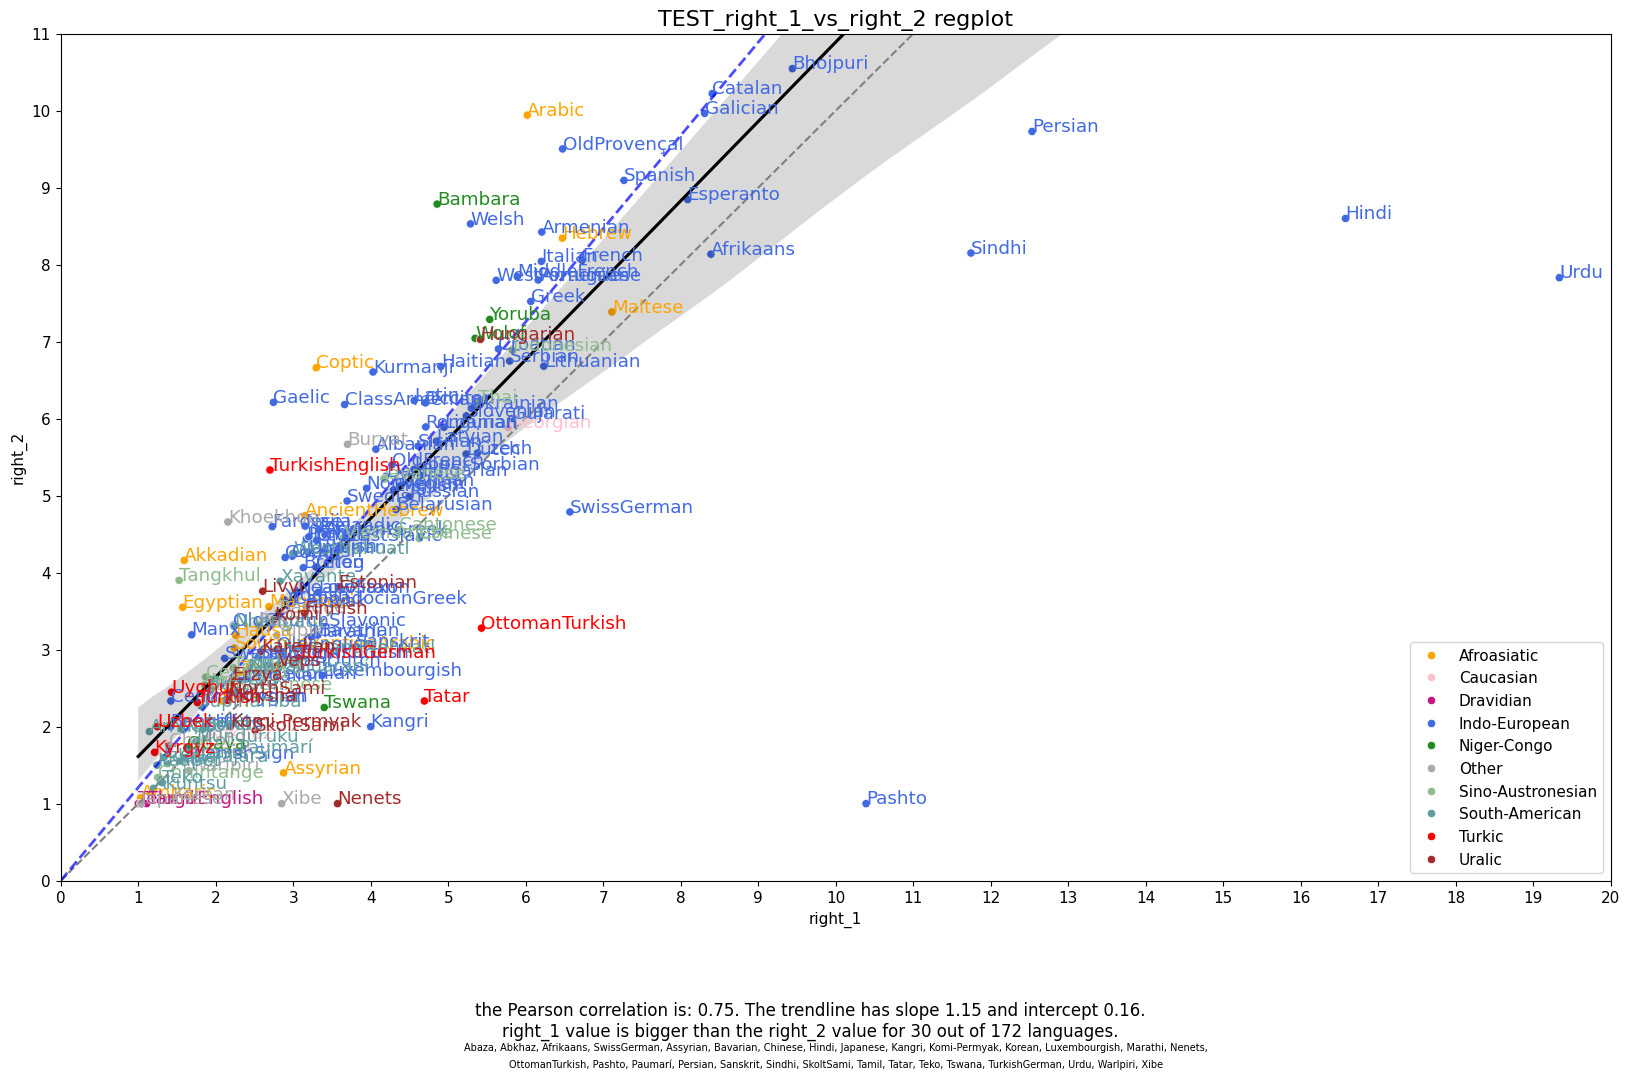

In [12]:
# Test with a simple comparison: right_1 vs right_2
print("Testing plot_dependency_sizes with right_1 vs right_2")
plotting.plot_dependency_sizes(
    'right_1', 
    'right_2', 
    'TEST',
    all_langs_average_sizes_filtered,  
    filter_lang=filter_lang_all,
    langNames=langNames,
    langnameGroup=langnameGroup,
    langname_group_or_genus=langnameGroup,               
    folderprefix='', 

    palette=group_to_color)

## 5. Generate Plots: All Languages

Generate all scatter plots for all languages (this will take some time).

In [13]:
# Remove all content from the plots folder before generating new plots
import shutil

if os.path.exists(PLOTS_BASE_DIR):
    print(f"Removing existing plots directory: {PLOTS_BASE_DIR}")
    shutil.rmtree(PLOTS_BASE_DIR)
    print(f"✅ Removed {PLOTS_BASE_DIR}")

# Recreate directory structure
os.makedirs(PLOTS_BASE_DIR, exist_ok=True)
for dir_path in [SCATTERS_DIR, REGSCATTERS_DIR, IE_SCATTERS_DIR, IE_REGSCATTERS_DIR, 
                 NOIE_SCATTERS_DIR, NOIE_REGSCATTERS_DIR, HEADINIT_SCATTERS_DIR, HEADINIT_REGSCATTERS_DIR,
                 HEADFINAL_SCATTERS_DIR, HEADFINAL_REGSCATTERS_DIR, FACTORHISTOGRAMS_DIR,
                 IE_FACTORHISTOGRAMS_DIR, NOIE_FACTORHISTOGRAMS_DIR, HEADINIT_FACTORHISTOGRAMS_DIR,
                 HEADFINAL_FACTORHISTOGRAMS_DIR]:
    os.makedirs(dir_path, exist_ok=True)
print(f"✅ Recreated clean directory structure under: {PLOTS_BASE_DIR}")

# Generate all plots for all languages
plot_all(filter_lang_all)

Removing existing plots directory: plots
✅ Removed plots
✅ Recreated clean directory structure under: plots
_________________________ plotting all ___________________________ 
Total plots to generate: 60
Using 80 CPU cores for parallel processing


✓ Saved plot: plots/scatters/right pos 1 tot 3 vs tot 2 MAL.png

✓ Saved plot: plots/scatters/right pos 2 tot 5 vs tot 4 MAL.png
✓ Saved plot: plots/scatters/right pos 1 tot 4 vs tot 3 MAL.png
✓ Saved plot: plots/scatters/right pos 3 tot 5 vs tot 4 MAL.png
✓ Saved plot: plots/scatters/right pos 2 tot 5 vs tot 4 MAL.png
✓ Saved plot: plots/scatters/right pos 1 tot 4 vs tot 3 MAL.png
✓ Saved plot: plots/scatters/right pos 3 tot 5 vs tot 4 MAL.png
✓ Saved plot: plots/scatters/right pos 1 tot 5 vs tot 4 MAL.png
✓ Saved plot: plots/scatters/right tot 5 pos 2 vs pos 3 HCS.png✓ Saved plot: plots/scatters/right tot 5 pos 3 vs pos 4 HCS.png

✓ Saved plot: plots/scatters/right pos 1 tot 5 vs tot 4 MAL.png
✓ Saved plot: plots/scatters/right tot 5 pos 2 vs pos 3 HCS.png✓ Saved plot: plots/scatters/right tot 5 pos 3 vs pos 4 HCS.png

✓ Saved plot: plots/scatters/right tot 4 pos 2 vs pos 3 HCS.png
✓ Saved plot: plots/scatters/right tot 4 pos 2 vs pos 3 HCS.png
✓ Saved plot: plots/scatters/left pos 1

## 6. Generate Plots: Indo-European Languages Only

In [14]:
def filter_lang_IE(lang):
    """Include only Indo-European languages."""
    lang_name = langNames.get(lang, lang)
    return langnameGroup.get(lang_name, '') == 'Indo-European'

plot_all(
    filter_lang_IE, 
    langname_group_or_genus=IElangnameGenus, 
    folderprefix='IE-', 
    palette=IEgenus_to_color
)

_________________________ plotting all ___________________________ IE-
Total plots to generate: 60
Using 80 CPU cores for parallel processing
✓ Saved plot: plots/IE-scatters/right pos 1 tot 3 vs tot 2 MAL.png
✓ Saved plot: plots/IE-scatters/right pos 1 tot 3 vs tot 2 MAL.png
✓ Saved plot: plots/IE-scatters/right pos 3 tot 5 vs tot 4 MAL.png
✓ Saved plot: plots/IE-scatters/right pos 3 tot 5 vs tot 4 MAL.png
✓ Saved plot: plots/IE-scatters/right tot 5 pos 3 vs pos 4 HCS.png✓ Saved plot: plots/IE-scatters/right pos 2 tot 5 vs tot 4 MAL.png

✓ Saved plot: plots/IE-scatters/left pos 3 tot 5 vs tot 4 MAL.png
✓ Saved plot: plots/IE-scatters/right pos 1 tot 4 vs tot 3 MAL.png✓ Saved plot: plots/IE-scatters/left pos 3 tot 4 vs tot 3 MAL.png

✓ Saved plot: plots/IE-scatters/right tot 5 pos 3 vs pos 4 HCS.png✓ Saved plot: plots/IE-scatters/right pos 2 tot 5 vs tot 4 MAL.png

✓ Saved plot: plots/IE-scatters/left pos 3 tot 5 vs tot 4 MAL.png
✓ Saved plot: plots/IE-scatters/right pos 1 tot 4 vs tot 

In [15]:
# Generate factor histograms for IE languages
results_IE = plot_all_factors(
    all_langs_average_sizes_filtered,
    langNames,
    langnameGroup,
    group_to_color,
    output_folder=IE_FACTORHISTOGRAMS_DIR,
    filter_lang=filter_lang_IE,
    parallel=True
)

_________________________ Computing HCS factors ___________________________
Total factor plots to generate: 60
Using 80 CPU cores for parallel processing

✅ Completed 60 factor plots
  right pos 1 tot 2 vs tot 1 MAL, avg=2.5335
  right pos 1 tot 3 vs tot 2 MAL, avg=1.2332
  right pos 2 tot 3 vs tot 2 MAL, avg=2.2947
  right pos 1 tot 4 vs tot 3 MAL, avg=1.1916
  right pos 2 tot 4 vs tot 3 MAL, avg=1.2571
  ... and 55 more

✅ Completed 60 factor plots
  right pos 1 tot 2 vs tot 1 MAL, avg=2.5335
  right pos 1 tot 3 vs tot 2 MAL, avg=1.2332
  right pos 2 tot 3 vs tot 2 MAL, avg=2.2947
  right pos 1 tot 4 vs tot 3 MAL, avg=1.1916
  right pos 2 tot 4 vs tot 3 MAL, avg=1.2571
  ... and 55 more


## 7. Generate Plots: Non-Indo-European Languages Only

In [16]:
def filter_lang_noIE(lang):
    """Include only non-Indo-European languages."""
    lang_name = langNames.get(lang, lang)
    return langnameGroup.get(lang_name, '') != 'Indo-European'

plot_all(
    filter_lang_noIE, 
    folderprefix='noIE-', 
    palette=group_to_color
)

_________________________ plotting all ___________________________ noIE-
Total plots to generate: 60
Using 80 CPU cores for parallel processing
✓ Saved plot: plots/noIE-scatters/right pos 2 tot 4 vs tot 3 MAL.png✓ Saved plot: plots/noIE-scatters/right pos 2 tot 4 vs tot 3 MAL.png

✓ Saved plot: plots/noIE-scatters/right pos 2 tot 5 vs tot 4 MAL.png✓ Saved plot: plots/noIE-scatters/right pos 1 tot 5 vs tot 4 MAL.png

✓ Saved plot: plots/noIE-scatters/right pos 2 tot 5 vs tot 4 MAL.png✓ Saved plot: plots/noIE-scatters/right pos 1 tot 5 vs tot 4 MAL.png

✓ Saved plot: plots/noIE-scatters/right pos 1 tot 3 vs tot 2 MAL.png✓ Saved plot: plots/noIE-scatters/right pos 3 tot 5 vs tot 4 MAL.png

✓ Saved plot: plots/noIE-scatters/right pos 1 tot 3 vs tot 2 MAL.png✓ Saved plot: plots/noIE-scatters/right pos 3 tot 5 vs tot 4 MAL.png

✓ Saved plot: plots/noIE-scatters/right tot 4 pos 1 vs pos 2 HCS.png
✓ Saved plot: plots/noIE-scatters/right tot 4 pos 1 vs pos 2 HCS.png
✓ Saved plot: plots/noIE-sca

In [17]:
# Generate factor histograms for non-IE languages
results_noIE = plot_all_factors(
    all_langs_average_sizes_filtered,
    langNames,
    langnameGroup,
    group_to_color,
    output_folder=NOIE_FACTORHISTOGRAMS_DIR,
    filter_lang=filter_lang_noIE,
    parallel=True
)

_________________________ Computing HCS factors ___________________________
Total factor plots to generate: 60
Using 80 CPU cores for parallel processing

✅ Completed 60 factor plots
  right pos 1 tot 2 vs tot 1 MAL, avg=1.7925
  right pos 1 tot 3 vs tot 2 MAL, avg=1.1533
  right pos 2 tot 3 vs tot 2 MAL, avg=1.7963
  right pos 1 tot 4 vs tot 3 MAL, avg=1.0108
  right pos 2 tot 4 vs tot 3 MAL, avg=1.1472
  ... and 55 more

✅ Completed 60 factor plots
  right pos 1 tot 2 vs tot 1 MAL, avg=1.7925
  right pos 1 tot 3 vs tot 2 MAL, avg=1.1533
  right pos 2 tot 3 vs tot 2 MAL, avg=1.7963
  right pos 1 tot 4 vs tot 3 MAL, avg=1.0108
  right pos 2 tot 4 vs tot 3 MAL, avg=1.1472
  ... and 55 more


## factor computation

compute the HCS factor "right tot 2 pos 2" divided by "right tot 2 pos 1" for all languages. make a pd dataframe.
plot this factor 

In [18]:
# Compute HCS factor: right_2_totright_2 / right_1_totright_2
hcs_data = []

for lang in all_langs_average_sizes_filtered:
    lang_name = langNames.get(lang, lang)
    group = langnameGroup.get(lang_name, 'Unknown')
    
    # Get the two positions
    pos1_key = 'right_1_totright_2'  # position 1, total 2
    pos2_key = 'right_2_totright_2'  # position 2, total 2
    
    if pos1_key in all_langs_average_sizes_filtered[lang] and pos2_key in all_langs_average_sizes_filtered[lang]:
        pos1_val = all_langs_average_sizes_filtered[lang][pos1_key]
        pos2_val = all_langs_average_sizes_filtered[lang][pos2_key]
        
        # Compute factor (avoid division by zero)
        if pos1_val > 0:
            hcs_factor = pos2_val / pos1_val
            hcs_data.append({
                'language_code': lang,
                'language_name': lang_name,
                'group': group,
                'right_1_totright_2': pos1_val,
                'right_2_totright_2': pos2_val,
                'hcs_factor': hcs_factor
            })

# Create DataFrame
hcs_df = pd.DataFrame(hcs_data)
hcs_df = hcs_df.sort_values('hcs_factor')

print(f"Computed HCS factor for {len(hcs_df)} languages")
print("\nSample data:")
print(hcs_df.head(10))
print("\nSummary statistics:")
print(hcs_df['hcs_factor'].describe())

Computed HCS factor for 171 languages

Sample data:
    language_code  language_name           group  right_1_totright_2  \
81             ko         Korean           Other            1.881159   
117           pad        Paumarí  South-American            2.333333   
147            tn         Tswana     Niger-Congo            2.500000   
138           ssp    SpanishSign   Indo-European            1.750000   
71             ja       Japanese           Other            1.000000   
74            xnr         Kangri   Indo-European            2.000000   
166           sjo           Xibe           Other            1.000000   
4             aqz        Akuntsu  South-American            1.200000   
142            ta          Tamil       Dravidian            1.000000   
145           qte  TeluguEnglish       Dravidian            1.000000   

     right_2_totright_2  hcs_factor  
81             1.060870    0.563945  
117            1.666667    0.714286  
147            2.250000    0.900000  
138

In [19]:
# Reload plotting module to pick up the new plot_hcs_factor function
import importlib
importlib.reload(plotting)

<module 'plotting' from '/bigstorage/kim/typometrics/dataanalysis/plotting.py'>

In [20]:
# Generate all HCS factor plots
results = plot_all_factors(
    all_langs_average_sizes_filtered,
    langNames,
    langnameGroup,
    group_to_color,
    output_folder=FACTORHISTOGRAMS_DIR,
    parallel=True
)

_________________________ Computing HCS factors ___________________________
Total factor plots to generate: 60
Using 80 CPU cores for parallel processing

✅ Completed 60 factor plots
  right pos 1 tot 2 vs tot 1 MAL, avg=2.1652
  right pos 1 tot 3 vs tot 2 MAL, avg=1.1941
  right pos 2 tot 3 vs tot 2 MAL, avg=2.0507
  right pos 1 tot 4 vs tot 3 MAL, avg=1.1143
  right pos 2 tot 4 vs tot 3 MAL, avg=1.2101
  ... and 55 more

✅ Completed 60 factor plots
  right pos 1 tot 2 vs tot 1 MAL, avg=2.1652
  right pos 1 tot 3 vs tot 2 MAL, avg=1.1941
  right pos 2 tot 3 vs tot 2 MAL, avg=2.0507
  right pos 1 tot 4 vs tot 3 MAL, avg=1.1143
  right pos 2 tot 4 vs tot 3 MAL, avg=1.2101
  ... and 55 more


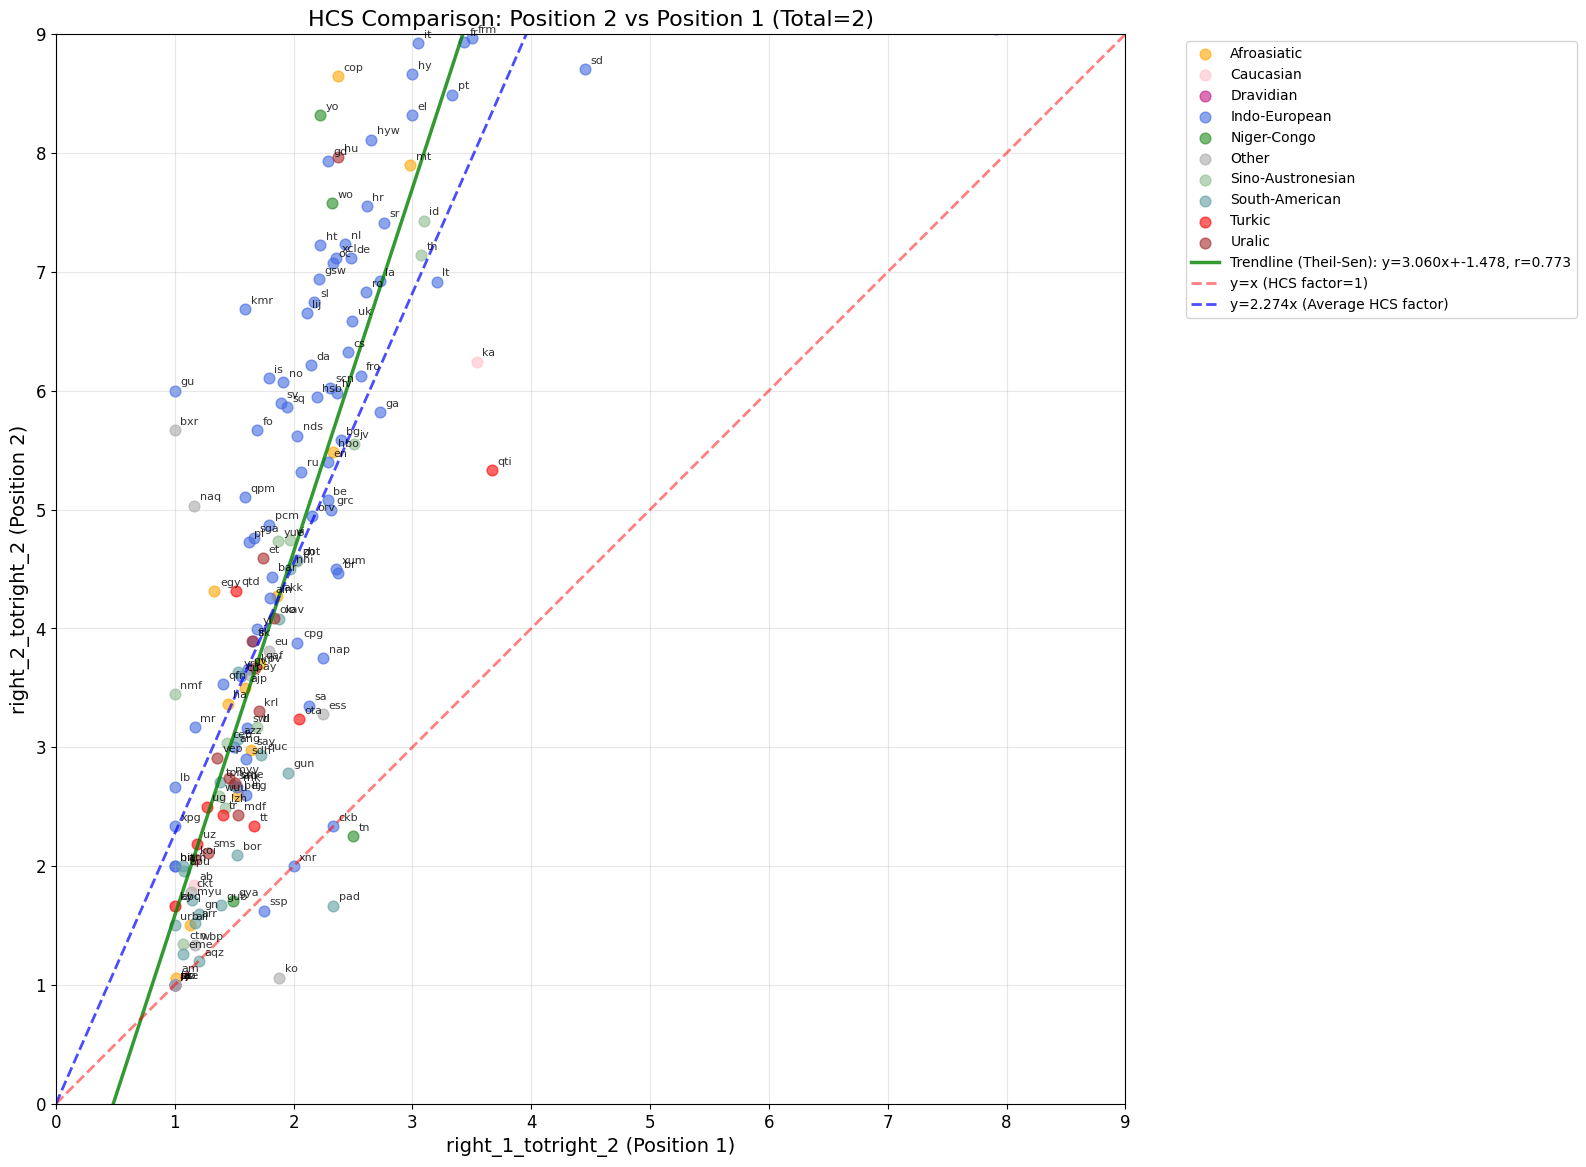

✅ Scatter plot saved to hcs_factor_scatter.png
Trendline: y = 3.0603x + -1.4776
Pearson correlation: r = 0.7731
Average HCS factor: 2.2735


In [21]:
# Plot 2: Scatter plot colored by language group (separate figure)
fig, ax = plt.subplots(1, 1, figsize=(16, 16))

# Compute average HCS factor
avg_hcs_factor = hcs_df['hcs_factor'].mean()

for group in sorted(hcs_df['group'].unique()):
    group_data = hcs_df[hcs_df['group'] == group]
    ax.scatter(
        group_data['right_1_totright_2'], 
        group_data['right_2_totright_2'],
        c=[group_to_color.get(group, '#888888')],
        label=group,
        alpha=0.6,
        s=60
    )

# Add language codes next to each point
for _, row in hcs_df.iterrows():
    ax.annotate(
        row['language_code'],
        (row['right_1_totright_2'], row['right_2_totright_2']),
        fontsize=8,
        alpha=0.8,
        xytext=(4, 4),  # offset from point
        textcoords='offset points'
    )

# Compute and plot trendline using Theil-Sen regression (robust to outliers)
from sklearn.linear_model import TheilSenRegressor
X = hcs_df['right_1_totright_2'].values.reshape(-1, 1)
y = hcs_df['right_2_totright_2'].values
regressor = TheilSenRegressor(random_state=42)
regressor.fit(X, y)
x_trend = np.array([0, 9]).reshape(-1, 1)
y_trend = regressor.predict(x_trend)

# Compute Pearson correlation
r_pearson, _ = stats.pearsonr(hcs_df['right_1_totright_2'], hcs_df['right_2_totright_2'])

ax.plot(x_trend, y_trend, 'g-', alpha=0.8, linewidth=2.5, 
        label=f'Trendline (Theil-Sen): y={regressor.coef_[0]:.3f}x+{regressor.intercept_:.3f}, r={r_pearson:.3f}')

# Add diagonal reference line (HCS factor = 1)
ax.plot([0, 9], [0, 9], 'r--', alpha=0.5, label='y=x (HCS factor=1)', linewidth=2)

# Add line with slope = avg_hcs_factor from origin
ax.plot([0, 9], [0, 9 * avg_hcs_factor], 'b--', alpha=0.7, 
        label=f'y={avg_hcs_factor:.3f}x (Average HCS factor)', linewidth=2)

# Set axis limits precisely and ensure square aspect ratio
ax.set_xlim(0, 9)
ax.set_ylim(0, 9)
ax.set_aspect('equal', adjustable='box')

ax.set_xlabel('right_1_totright_2 (Position 1)', fontsize=14)
ax.set_ylabel('right_2_totright_2 (Position 2)', fontsize=14)
ax.set_title('HCS Comparison: Position 2 vs Position 1 (Total=2)', fontsize=16)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
ax.grid(alpha=0.3)
ax.tick_params(labelsize=12)

plt.tight_layout()
plt.savefig('hcs_factor_scatter.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ Scatter plot saved to hcs_factor_scatter.png")
print(f"Trendline: y = {regressor.coef_[0]:.4f}x + {regressor.intercept_:.4f}")
print(f"Pearson correlation: r = {r_pearson:.4f}")
print(f"Average HCS factor: {avg_hcs_factor:.4f}")

In [22]:
# Display languages with highest and lowest HCS factors
print("="*80)
print("Languages with LOWEST HCS factors (Position 2 smaller relative to Position 1):")
print("="*80)
print(hcs_df[['language_name', 'group', 'right_1_totright_2', 'right_2_totright_2', 'hcs_factor']].head(15).to_string(index=False))

print("\n" + "="*80)
print("Languages with HIGHEST HCS factors (Position 2 larger relative to Position 1):")
print("="*80)
print(hcs_df[['language_name', 'group', 'right_1_totright_2', 'right_2_totright_2', 'hcs_factor']].tail(15).to_string(index=False))

# Save to CSV
hcs_df.to_csv('hcs_factor_results.csv', index=False)
print(f"\n✅ Results saved to hcs_factor_results.csv")

Languages with LOWEST HCS factors (Position 2 smaller relative to Position 1):
 language_name          group  right_1_totright_2  right_2_totright_2  hcs_factor
        Korean          Other            1.881159            1.060870    0.563945
       Paumarí South-American            2.333333            1.666667    0.714286
        Tswana    Niger-Congo            2.500000            2.250000    0.900000
   SpanishSign  Indo-European            1.750000            1.625000    0.928571
      Japanese          Other            1.000000            1.000000    1.000000
        Kangri  Indo-European            2.000000            2.000000    1.000000
          Xibe          Other            1.000000            1.000000    1.000000
       Akuntsu South-American            1.200000            1.200000    1.000000
         Tamil      Dravidian            1.000000            1.000000    1.000000
 TeluguEnglish      Dravidian            1.000000            1.000000    1.000000
        Pashto  Ind

## Summary

This notebook has:
- ✅ Loaded analysis results from notebook 02
- ✅ Created color palettes for language groups and IE genera
- ✅ Generated scatter plots for all languages (plots/scatters/ and plots/regscatters/)
- ✅ Generated scatter plots for IE languages only (plots/IE-scatters/ and plots/IE-regscatters/)
- ✅ Generated scatter plots for non-IE languages (plots/noIE-scatters/ and plots/noIE-regscatters/)
- ✅ Generated factor histograms (plots/factorhistograms/)
- ✅ Created zip archive of all plots

**Plot types generated**:
- **MAL**: Mean Aggregate Length comparisons (same position, different total contexts)
- **HCS**: Hierarchical Complexity Scores (adjacent positions with same total)
- **DIAG**: Diagonal comparisons (same position k, different total contexts n and m)

Each plot includes:
- Scatter plot with language labels
- Diagonal reference line
- Pearson correlation coefficient
- Regression plot with Theil-Sen trendline and average factor line

**Directory structure**:
```
plots/
├── scatters/           # Scatter plots for all languages
├── regscatters/        # Regression plots for all languages (with average factor line)
├── IE-scatters/        # Scatter plots for IE languages only
├── IE-regscatters/     # Regression plots for IE languages only (with average factor line)
├── noIE-scatters/      # Scatter plots for non-IE languages
├── noIE-regscatters/   # Regression plots for non-IE languages (with average factor line)
└── factorhistograms/   # Factor histograms (bar charts)
```

## 9. Head-Initiality Analysis

Compute head-initiality for each language: the percentage of VERB-complement relations that go to the right.

Head-initiality = (right dependents / total dependents) × 100

In [24]:
# Compute head-initiality for each language
head_initiality_data = []

for lang in all_langs_position2num:
    lang_name = langNames.get(lang, lang)
    group = langnameGroup.get(lang_name, 'Unknown')
    
    # Count all right dependents
    right_count = sum(
        count for key, count in all_langs_position2num[lang].items()
        if key.startswith('right_')
    )
    
    # Count all left dependents
    left_count = sum(
        count for key, count in all_langs_position2num[lang].items()
        if key.startswith('left_')
    )
    
    # Calculate head-initiality (percentage of right dependents)
    total_count = right_count + left_count
    if total_count > 0:
        head_initiality = (right_count / total_count) * 100
        head_initiality_data.append({
            'language_code': lang,
            'language_name': lang_name,
            'group': group,
            'right_count': right_count,
            'left_count': left_count,
            'total_count': total_count,
            'head_initiality': head_initiality
        })

# Create DataFrame
head_initiality_df = pd.DataFrame(head_initiality_data)
head_initiality_df = head_initiality_df.sort_values('head_initiality')

print(f"Computed head-initiality for {len(head_initiality_df)} languages")
print("\nSummary statistics:")
print(head_initiality_df['head_initiality'].describe())

print("\n10 most head-final languages (lowest head-initiality):")
print(head_initiality_df[['language_name', 'group', 'head_initiality']].head(10).to_string(index=False))

print("\n10 most head-initial languages (highest head-initiality):")
print(head_initiality_df[['language_name', 'group', 'head_initiality']].tail(10).to_string(index=False))

Computed head-initiality for 186 languages

Summary statistics:
count    186.000000
mean      38.318004
std       23.430422
min        0.000000
25%       17.291673
50%       40.941883
75%       54.732451
max       98.325948
Name: head_initiality, dtype: float64

10 most head-final languages (lowest head-initiality):
language_name         group  head_initiality
   OldTurkish        Turkic         0.000000
     Japanese         Other         0.420256
         Xibe         Other         0.428922
       Kazakh        Turkic         0.854701
    Sinhalese Indo-European         0.892857
       Telugu     Dravidian         1.074345
        Yakut        Turkic         1.402806
       Kyrgyz        Turkic         1.570289
       Uyghur        Turkic         1.978202
      Hittite Indo-European         2.191235

10 most head-initial languages (highest head-initiality):
       language_name             group  head_initiality
              Breton     Indo-European        74.468085
               W

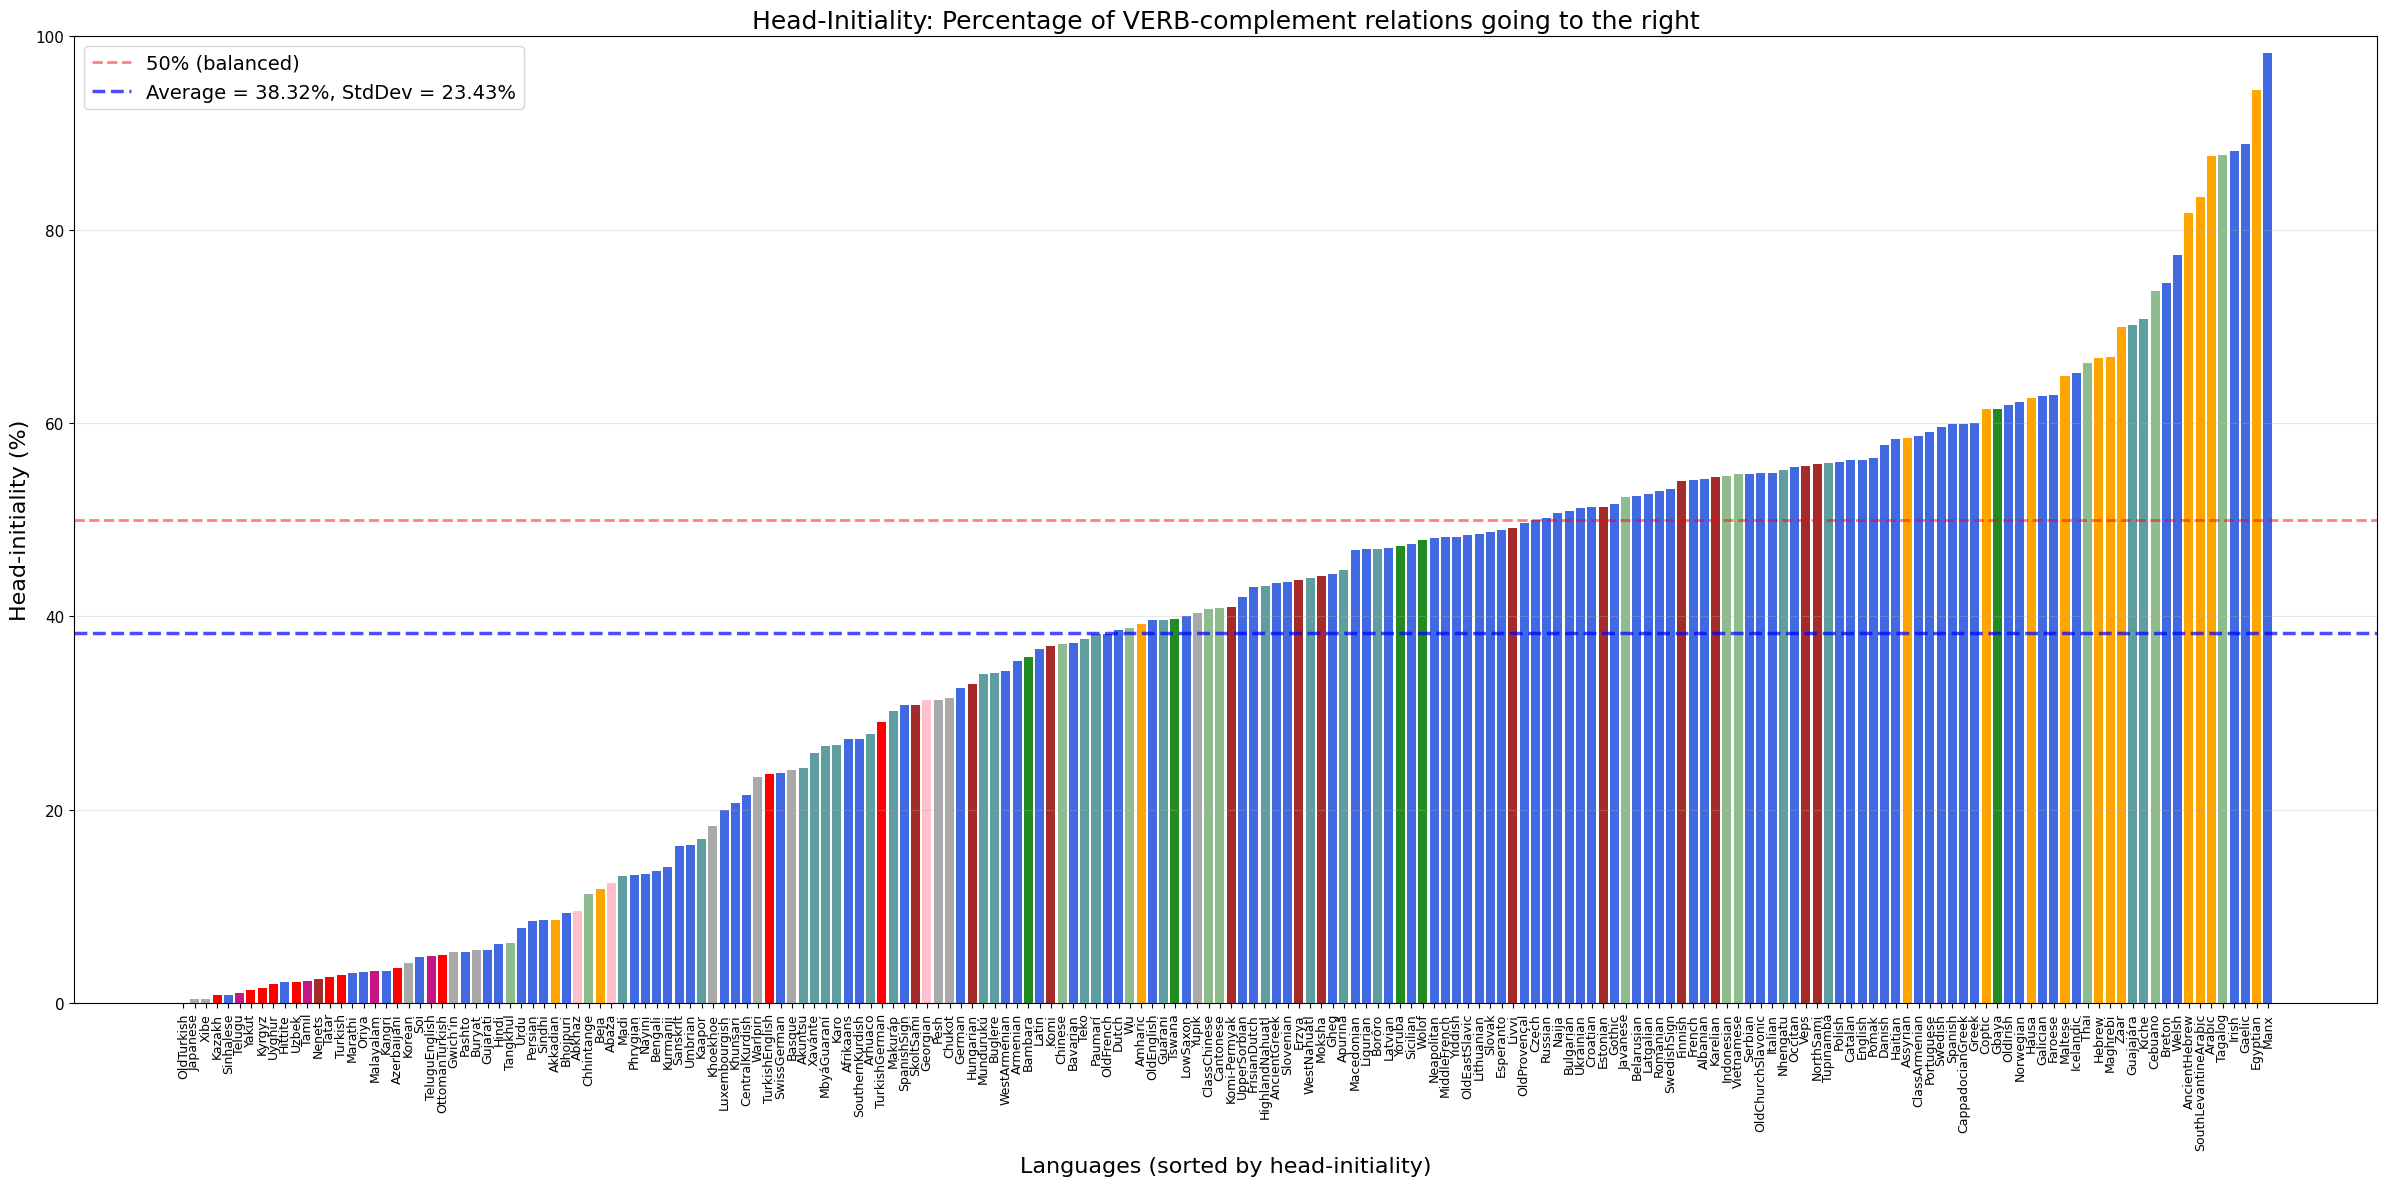

✅ Head-initiality histogram saved to plots/head_initiality_histogram.png
Average head-initiality: 38.32%
Standard deviation: 23.43%


In [25]:
# Create histogram of head-initiality
fig, ax = plt.subplots(1, 1, figsize=(24, 12))

# Get colors for each language based on group
colors = [group_to_color.get(group, '#888888') for group in head_initiality_df['group']]

# Create bar plot
bars = ax.bar(range(len(head_initiality_df)), head_initiality_df['head_initiality'], color=colors)

# Compute statistics
avg_head_initiality = head_initiality_df['head_initiality'].mean()
std_head_initiality = head_initiality_df['head_initiality'].std()

# Add reference lines
ax.axhline(y=50.0, color='red', linestyle='--', alpha=0.5, linewidth=2, label='50% (balanced)')
ax.axhline(y=avg_head_initiality, color='blue', linestyle='--', alpha=0.7, linewidth=2.5, 
           label=f'Average = {avg_head_initiality:.2f}%, StdDev = {std_head_initiality:.2f}%')

ax.set_xlabel('Languages (sorted by head-initiality)', fontsize=16)
ax.set_ylabel('Head-initiality (%)', fontsize=16)
ax.set_title('Head-Initiality: Percentage of VERB-complement relations going to the right', fontsize=18)
ax.legend(fontsize=14, loc='upper left')
ax.grid(axis='y', alpha=0.3)
ax.set_ylim(0, 100)

# Add language names below bars
ax.set_xticks(range(len(head_initiality_df)))
ax.set_xticklabels(head_initiality_df['language_name'], rotation=90, fontsize=9, ha='center')

plt.tight_layout()

# Save plot
os.makedirs('plots', exist_ok=True)
plt.savefig('plots/head_initiality_histogram.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ Head-initiality histogram saved to plots/head_initiality_histogram.png")
print(f"Average head-initiality: {avg_head_initiality:.2f}%")
print(f"Standard deviation: {std_head_initiality:.2f}%")

In [26]:
# Save head-initiality results to CSV
head_initiality_df.to_csv('head_initiality_results.csv', index=False)
print(f"✅ Head-initiality results saved to head_initiality_results.csv")

✅ Head-initiality results saved to head_initiality_results.csv


## 10. Generate Plots: Head-Initial Languages (>50% head-initiality)

In [27]:
# Create a set of head-initial language codes for filtering
head_initial_langs = set(head_initiality_df[head_initiality_df['head_initiality'] > 50]['language_code'])

def filter_lang_headInit(lang):
    """Include only head-initial languages (>50% head-initiality)."""
    return lang in head_initial_langs

print(f"Head-initial languages: {len(head_initial_langs)}")

# Generate plots for head-initial languages
plot_all(
    filter_lang_headInit, 
    folderprefix='headInit-', 
    palette=group_to_color
)

Head-initial languages: 66
_________________________ plotting all ___________________________ headInit-
Total plots to generate: 60
Using 80 CPU cores for parallel processing
✓ Saved plot: plots/headInit-scatters/right pos 1 tot 2 vs tot 1 MAL.png
✓ Saved plot: plots/headInit-scatters/right pos 1 tot 2 vs tot 1 MAL.png
✓ Saved plot: plots/headInit-scatters/right tot 2 pos 1 vs pos 2 HCS.png
✓ Saved plot: plots/headInit-scatters/right tot 2 pos 1 vs pos 2 HCS.png
✓ Saved plot: plots/headInit-scatters/left tot 4 pos 2 vs pos 3 HCS.png✓ Saved plot: plots/headInit-scatters/left pos 2 tot 5 vs tot 4 MAL.png

✓ Saved plot: plots/headInit-scatters/right pos 3 tot 5 vs tot 4 MAL.png
✓ Saved plot: plots/headInit-scatters/right pos 3 tot 4 vs tot 3 MAL.png✓ Saved plot: plots/headInit-scatters/left tot 4 pos 2 vs pos 3 HCS.png✓ Saved plot: plots/headInit-scatters/left pos 2 tot 5 vs tot 4 MAL.png

✓ Saved plot: plots/headInit-scatters/right pos 3 tot 5 vs tot 4 MAL.png
✓ Saved plot: plots/headIni

In [28]:
# Generate factor histograms for head-initial languages
results_headInit = plot_all_factors(
    all_langs_average_sizes_filtered,
    langNames,
    langnameGroup,
    group_to_color,
    output_folder=HEADINIT_FACTORHISTOGRAMS_DIR,
    filter_lang=filter_lang_headInit,
    parallel=True
)

_________________________ Computing HCS factors ___________________________
Total factor plots to generate: 60
Using 80 CPU cores for parallel processing

✅ Completed 60 factor plots
  right pos 1 tot 2 vs tot 1 MAL, avg=2.2446
  right pos 1 tot 3 vs tot 2 MAL, avg=1.2091
  right pos 2 tot 3 vs tot 2 MAL, avg=1.9732
  right pos 1 tot 4 vs tot 3 MAL, avg=1.0100
  right pos 2 tot 4 vs tot 3 MAL, avg=1.2446
  ... and 55 more

✅ Completed 60 factor plots
  right pos 1 tot 2 vs tot 1 MAL, avg=2.2446
  right pos 1 tot 3 vs tot 2 MAL, avg=1.2091
  right pos 2 tot 3 vs tot 2 MAL, avg=1.9732
  right pos 1 tot 4 vs tot 3 MAL, avg=1.0100
  right pos 2 tot 4 vs tot 3 MAL, avg=1.2446
  ... and 55 more


## 11. Generate Plots: Head-Final Languages (≤50% head-initiality)

In [29]:
# Create a set of head-final language codes for filtering
head_final_langs = set(head_initiality_df[head_initiality_df['head_initiality'] <= 50]['language_code'])

def filter_lang_headFinal(lang):
    """Include only head-final languages (≤50% head-initiality)."""
    return lang in head_final_langs

print(f"Head-final languages: {len(head_final_langs)}")

# Generate plots for head-final languages
plot_all(
    filter_lang_headFinal, 
    folderprefix='headFinal-', 
    palette=group_to_color
)

Head-final languages: 120
_________________________ plotting all ___________________________ headFinal-
Total plots to generate: 60
Using 80 CPU cores for parallel processing
✓ Saved plot: plots/headFinal-scatters/right pos 1 tot 5 vs tot 4 MAL.png
✓ Saved plot: plots/headFinal-scatters/right pos 2 tot 4 vs tot 3 MAL.png
✓ Saved plot: plots/headFinal-scatters/right pos 3 tot 5 vs tot 4 MAL.png✓ Saved plot: plots/headFinal-scatters/right pos 1 tot 4 vs tot 3 MAL.png✓ Saved plot: plots/headFinal-scatters/right pos 2 tot 5 vs tot 4 MAL.png


✓ Saved plot: plots/headFinal-scatters/right tot 5 pos 3 vs pos 4 HCS.png
✓ Saved plot: plots/headFinal-scatters/right pos 1 tot 5 vs tot 4 MAL.png
✓ Saved plot: plots/headFinal-scatters/right pos 2 tot 4 vs tot 3 MAL.png
✓ Saved plot: plots/headFinal-scatters/right pos 3 tot 5 vs tot 4 MAL.png✓ Saved plot: plots/headFinal-scatters/right pos 1 tot 4 vs tot 3 MAL.png✓ Saved plot: plots/headFinal-scatters/right pos 2 tot 5 vs tot 4 MAL.png


✓ Saved plo

In [30]:
# Generate factor histograms for head-final languages
results_headFinal = plot_all_factors(
    all_langs_average_sizes_filtered,
    langNames,
    langnameGroup,
    group_to_color,
    output_folder=HEADFINAL_FACTORHISTOGRAMS_DIR,
    filter_lang=filter_lang_headFinal,
    parallel=True
)

_________________________ Computing HCS factors ___________________________
Total factor plots to generate: 60
Using 80 CPU cores for parallel processing

✅ Completed 60 factor plots
  right pos 1 tot 2 vs tot 1 MAL, avg=2.1152
  right pos 1 tot 3 vs tot 2 MAL, avg=1.1815
  right pos 2 tot 3 vs tot 2 MAL, avg=2.1153
  right pos 1 tot 4 vs tot 3 MAL, avg=1.2319
  right pos 2 tot 4 vs tot 3 MAL, avg=1.1713
  ... and 55 more

✅ Completed 60 factor plots
  right pos 1 tot 2 vs tot 1 MAL, avg=2.1152
  right pos 1 tot 3 vs tot 2 MAL, avg=1.1815
  right pos 2 tot 3 vs tot 2 MAL, avg=2.1153
  right pos 1 tot 4 vs tot 3 MAL, avg=1.2319
  right pos 2 tot 4 vs tot 3 MAL, avg=1.1713
  ... and 55 more


## 12. Head-Initiality vs Factors Analysis

Analyze the relationship between head-initiality and various linguistic factors (MAL, HCS, DIAG).

In [31]:
def compute_all_factors(all_langs_average_sizes_filtered, langNames, langnameGroup, head_initiality_df):
    """
    Compute all linguistic factors for each language and merge with head-initiality data.
    
    Returns a DataFrame with all factors for all languages.
    """
    measures = [
        ('MAL', 'right_{k}_totright_{m}', 'right_{k}_totright_{n}', [1,5], [1,5]),
        ('MAL', 'left_{k}_totleft_{m}', 'left_{k}_totleft_{n}', [1,5], [1,5]),
        ('HCS', 'right_{j}_totright_{n}', 'right_{k}_totright_{n}', [2,6], [2,6]),
        ('HCS', 'left_{j}_totleft_{n}', 'left_{k}_totleft_{n}', [2,6], [2,6]),
        ('DIAG', 'right_{k}_totright_{n}', 'right_{l}_totright_{m}', [1,5], [1,5]),
        ('DIAG', 'left_{k}_totleft_{n}', 'left_{l}_totleft_{m}', [1,5], [1,5]),
    ]
    
    # Dictionary to store all factors for each language
    lang_factors = {}
    
    for (prefix, pos1, pos2, n_range, k_range) in measures:
        for n in range(*n_range):
            for k in range(*k_range):
                if k <= n:
                    m = n + 1
                    j = k - 1
                    l = k + 1
                    pos1_str = pos1.format(n=n, k=k, m=m, j=j, l=l)
                    pos2_str = pos2.format(n=n, k=k, m=m, j=j, l=l)
                    
                    # Generate factor name (same logic as in plotting)
                    def create_filename(pos_str):
                        parts = pos_str.split('_')
                        side = parts[0]
                        pos = parts[1]
                        if len(parts) >= 3 and 'tot' in parts[2]:
                            tot_part = parts[2]
                            if len(parts) == 4:
                                tot = parts[3]
                            else:
                                tot = tot_part.replace('tot' + side, '')
                            return side, pos, tot
                        else:
                            return side, pos, None
                    
                    side1, pos1_num, tot1 = create_filename(pos1_str)
                    side2, pos2_num, tot2 = create_filename(pos2_str)
                    
                    if prefix == 'MAL':
                        if tot1 and tot2:
                            factor_name = f"{side1} pos {pos1_num} tot {tot1} vs tot {tot2} MAL"
                        else:
                            factor_name = f"{side1} {pos1_str} vs {pos2_str} MAL"
                    elif prefix == 'HCS':
                        if tot1 and tot2:
                            factor_name = f"{side1} tot {tot1} pos {pos1_num} vs pos {pos2_num} HCS"
                        else:
                            factor_name = f"{side1} {pos1_str} vs {pos2_str} HCS"
                    elif prefix == 'DIAG':
                        if tot1 and tot2:
                            factor_name = f"{side1} pos {pos1_num} tot {tot1} vs pos {pos2_num} tot {tot2} DIAG"
                        else:
                            factor_name = f"{side1} {pos1_str} vs {pos2_str} DIAG"
                    else:
                        factor_name = f"{prefix} {pos1_str} vs {pos2_str}"
                    
                    # Compute factor for each language
                    for lang in all_langs_average_sizes_filtered:
                        if lang not in lang_factors:
                            lang_factors[lang] = {}
                        
                        if pos1_str in all_langs_average_sizes_filtered[lang] and pos2_str in all_langs_average_sizes_filtered[lang]:
                            pos1_val = all_langs_average_sizes_filtered[lang][pos1_str]
                            pos2_val = all_langs_average_sizes_filtered[lang][pos2_str]
                            
                            if pos1_val > 0:
                                factor = pos2_val / pos1_val
                                lang_factors[lang][factor_name] = factor
    
    # Convert to list of records
    records = []
    for lang in lang_factors:
        lang_name = langNames.get(lang, lang)
        group = langnameGroup.get(lang_name, 'Unknown')
        
        # Get head-initiality for this language
        head_init_row = head_initiality_df[head_initiality_df['language_code'] == lang]
        if len(head_init_row) > 0:
            head_initiality = head_init_row.iloc[0]['head_initiality']
        else:
            head_initiality = None
        
        record = {
            'language_code': lang,
            'language_name': lang_name,
            'group': group,
            'head_initiality': head_initiality
        }
        record.update(lang_factors[lang])
        records.append(record)
    
    return pd.DataFrame(records)

# Compute all factors
print("Computing all factors for all languages...")
all_factors_df = compute_all_factors(all_langs_average_sizes_filtered, langNames, langnameGroup, head_initiality_df)
print(f"✅ Computed {len(all_factors_df.columns) - 4} factors for {len(all_factors_df)} languages")
print(f"Factors: {[col for col in all_factors_df.columns if col not in ['language_code', 'language_name', 'group', 'head_initiality']][:5]}...")

Computing all factors for all languages...
✅ Computed 60 factors for 186 languages
Factors: ['right pos 1 tot 2 vs tot 1 MAL', 'left pos 1 tot 2 vs tot 1 MAL', 'left pos 1 tot 3 vs tot 2 MAL', 'left pos 2 tot 3 vs tot 2 MAL', 'left pos 1 tot 4 vs tot 3 MAL']...


In [32]:
# Reload plotting module to pick up the new function
import importlib
importlib.reload(plotting)

# Generate all scatter plots using the parallelized function from plotting module
results = plotting.plot_head_initiality_vs_factors(all_factors_df, group_to_color, parallel=True)

Generating 60 scatter plots...
  Progress: 10/60
  Progress: 10/60
  Progress: 20/60
  Progress: 20/60
  Progress: 30/60
  Progress: 30/60
  Progress: 40/60
  Progress: 40/60
  Progress: 50/60
  Progress: 50/60
  Progress: 60/60
  Progress: 60/60
✅ Completed scatter plots in plots/head_init_vs_factors/
✅ Completed scatter plots in plots/head_init_vs_factors/


In [33]:
# Save the all_factors DataFrame for future analysis
all_factors_df.to_csv('head_initiality_vs_factors.csv', index=False)
print(f"✅ Saved all factors data to head_initiality_vs_factors.csv")

✅ Saved all factors data to head_initiality_vs_factors.csv


## Last cell: Archive Results

In [ ]:
# Create zip archive of the plots folder
import subprocess

if os.path.exists('plots'):
    subprocess.run(['zip', '-r', 'plots-2.17.zip', 'plots'])
    print(f"Created plots.zip containing all plot subdirectories")

updating: plots/ (stored 0%)
updating: plots/scatters/ (stored 0%)
updating: plots/scatters/right pos 3 tot 5 vs tot 4 MAL.png (deflated 4%)
updating: plots/scatters/right pos 3 tot 4 vs tot 3 MAL.png (deflated 6%)
updating: plots/scatters/right pos 2 tot 4 vs tot 3 MAL.png (deflated 4%)
updating: plots/scatters/left pos 4 tot 5 vs tot 4 MAL.png (deflated 5%)
updating: plots/scatters/right tot 4 pos 1 vs pos 2 HCS.png (deflated 5%)
updating: plots/scatters/right pos 1 tot 5 vs tot 4 MAL.png (deflated 6%)
updating: plots/scatters/right pos 4 tot 5 vs tot 4 MAL.png (deflated 8%)
updating: plots/scatters/right pos 2 tot 5 vs tot 4 MAL.png (deflated 6%)
updating: plots/scatters/right pos 1 tot 3 vs tot 2 MAL.png (deflated 5%)
updating: plots/scatters/right tot 3 pos 1 vs pos 2 HCS.png (deflated 7%)
updating: plots/scatters/right pos 1 tot 4 vs tot 3 MAL.png (deflated 6%)
updating: plots/scatters/right tot 2 pos 1 vs pos 2 HCS.png (deflated 5%)
updating: plots/scatters/right tot 5 pos 4 vs 

## 13. Verb-Centered Constituent Size Table

Create a table showing average constituent sizes at each position relative to the verb, for different numbers of total constituents.

In [35]:
# Create verb-centered constituent size table
# Calculate average sizes across all languages for each position and total

def compute_average_sizes_table(all_langs_average_sizes_filtered):
    """
    Compute average constituent sizes at each position for different totals.
    Returns a table with:
    - Right side: positions 1,2,3,4 for totals 4,3,2,1
    - Left side: positions 1,2,3,4 for totals 1,2,3,4
    """
    # Dictionary to store sums and counts for averaging
    position_sums = {}
    position_counts = {}
    
    # Collect all values across languages
    for lang, positions in all_langs_average_sizes_filtered.items():
        for position_key, value in positions.items():
            if position_key not in position_sums:
                position_sums[position_key] = 0
                position_counts[position_key] = 0
            position_sums[position_key] += value
            position_counts[position_key] += 1
    
    # Calculate averages
    position_averages = {}
    for position_key in position_sums:
        if position_counts[position_key] > 0:
            position_averages[position_key] = position_sums[position_key] / position_counts[position_key]
    
    return position_averages

# Compute averages
position_averages = compute_average_sizes_table(all_langs_average_sizes_filtered)

# Build the table structure
# Right side: tot=4,3,2,1 (positions 1,2,3,4 for each)
# Left side: tot=1,2,3,4 (positions 1,2,3,4 for each)

print("=" * 80)
print("VERB-CENTERED CONSTITUENT SIZE TABLE")
print("Average constituent sizes across all languages")
print("=" * 80)
print()

# Right side of verb (dependents to the right)
print("RIGHT DEPENDENTS (after verb):")
print("-" * 80)
for tot in [4, 3, 2, 1]:
    row = []
    # Add positions from 1 to tot
    for pos in range(1, tot + 1):
        key = f'right_{pos}_totright_{tot}'
        if key in position_averages:
            row.append(f"{position_averages[key]:.3f}")
        else:
            row.append("N/A")
    
    # Build the display with V and positions
    if tot == 4:
        print(f"tot=4: V  {row[0]:>6}  {row[1]:>6}  {row[2]:>6}  {row[3]:>6}")
    elif tot == 3:
        print(f"tot=3: V  {row[0]:>6}  {row[1]:>6}  {row[2]:>6}")
    elif tot == 2:
        print(f"tot=2: V  {row[0]:>6}  {row[1]:>6}")
    elif tot == 1:
        print(f"tot=1: V  {row[0]:>6}")

print()
print("LEFT DEPENDENTS (before verb):")
print("-" * 80)

# Left side of verb (dependents to the left)
for tot in [1, 2, 3, 4]:
    row = []
    # Add positions from 1 to tot (rightmost to leftmost)
    for pos in range(1, tot + 1):
        key = f'left_{pos}_totleft_{tot}'
        if key in position_averages:
            row.append(f"{position_averages[key]:.3f}")
        else:
            row.append("N/A")
    
    # Build the display with positions and V (reversed order for left side)
    if tot == 1:
        print(f"tot=1: {row[0]:>6}  V")
    elif tot == 2:
        print(f"tot=2: {row[1]:>6}  {row[0]:>6}  V")
    elif tot == 3:
        print(f"tot=3: {row[2]:>6}  {row[1]:>6}  {row[0]:>6}  V")
    elif tot == 4:
        print(f"tot=4: {row[3]:>6}  {row[2]:>6}  {row[1]:>6}  {row[0]:>6}  V")

print()
print("=" * 80)
print("Note: Position 1 is closest to the verb, higher positions are farther away")
print("=" * 80)

VERB-CENTERED CONSTITUENT SIZE TABLE
Average constituent sizes across all languages

RIGHT DEPENDENTS (after verb):
--------------------------------------------------------------------------------
tot=4: V   1.873   2.374   3.263   6.660
tot=3: V   1.868   2.665   5.629
tot=2: V   2.061   4.771
tot=1: V   4.425

LEFT DEPENDENTS (before verb):
--------------------------------------------------------------------------------
tot=1:  2.349  V
tot=2:  1.932   2.491  V
tot=3:  1.812   2.181   2.719  V
tot=4:  1.702   2.098   2.638   3.084  V

Note: Position 1 is closest to the verb, higher positions are farther away


In [36]:
# Create a more visual table using pandas DataFrame
# This creates the exact table format requested: V X X X X structure

def create_verb_table(position_averages):
    """
    Create a verb-centered table showing constituent sizes.
    Format:
    Row 1 (tot=4 right): V X X X X
    Row 2 (tot=3 right): V X X X
    Row 3 (tot=2 right): V X X
    Row 4 (tot=1 right): V X
    Row 5 (tot=1 left):  X V
    Row 6 (tot=2 left):  X X V
    Row 7 (tot=3 left):  X X X V
    Row 8 (tot=4 left):  X X X X V
    """
    # Create data for DataFrame with 5 columns (max positions)
    data = []
    row_labels = []
    
    # Right dependents (tot=4,3,2,1)
    for tot in [4, 3, 2, 1]:
        row = [''] * 5
        row[0] = 'V'  # Verb position
        
        for pos in range(1, tot + 1):
            key = f'right_{pos}_totright_{tot}'
            if key in position_averages:
                row[pos] = f"{position_averages[key]:.3f}"
        
        data.append(row)
        row_labels.append(f'right tot={tot}')
    
    # Left dependents (tot=1,2,3,4)
    for tot in [1, 2, 3, 4]:
        row = [''] * 5
        row[tot] = 'V'  # Verb position moves right as tot increases
        
        for pos in range(1, tot + 1):
            key = f'left_{pos}_totleft_{tot}'
            if key in position_averages:
                # For left side, position 1 is closest to verb (immediately left)
                # So we fill from right to left
                row[tot - pos] = f"{position_averages[key]:.3f}"
        
        data.append(row)
        row_labels.append(f'left tot={tot}')
    
    # Create DataFrame
    df = pd.DataFrame(data, 
                      index=row_labels,
                      columns=['Col 1', 'Col 2', 'Col 3', 'Col 4', 'Col 5'])
    
    return df

# Create and display the table
verb_table = create_verb_table(position_averages)

print("\n" + "=" * 80)
print("VERB-CENTERED CONSTITUENT SIZE TABLE")
print("=" * 80)
print("\nTable format: Each row shows the verb (V) and average constituent sizes")
print("at each position for a given total number of dependents.\n")
print("RIGHT SIDE: Dependents after the verb")
print("LEFT SIDE: Dependents before the verb")
print("=" * 80)
print()
print(verb_table.to_string())
print()
print("=" * 80)
print("Note: Empty cells indicate no dependent at that position")
print("Position numbers increase with distance from the verb")
print("=" * 80)


VERB-CENTERED CONSTITUENT SIZE TABLE

Table format: Each row shows the verb (V) and average constituent sizes
at each position for a given total number of dependents.

RIGHT SIDE: Dependents after the verb
LEFT SIDE: Dependents before the verb

             Col 1  Col 2  Col 3  Col 4  Col 5
right tot=4      V  1.873  2.374  3.263  6.660
right tot=3      V  1.868  2.665  5.629       
right tot=2      V  2.061  4.771              
right tot=1      V  4.425                     
left tot=1   2.349      V                     
left tot=2   1.932  2.491      V              
left tot=3   1.812  2.181  2.719      V       
left tot=4   1.702  2.098  2.638  3.084      V

Note: Empty cells indicate no dependent at that position
Position numbers increase with distance from the verb


In [37]:
# Save the table to CSV
verb_table.to_csv('verb_centered_table.csv')
print(f"✅ Verb-centered table saved to verb_centered_table.csv")

✅ Verb-centered table saved to verb_centered_table.csv


In [38]:
# Create enhanced table with factors between consecutive positions
def create_verb_table_with_factors(position_averages):
    """
    Create a verb-centered table showing constituent sizes AND factors between consecutive positions.
    
    For each row, we alternate between:
    - Size values (e.g., 1.873, 2.374, 3.263)
    - Factor values showing how much bigger the next position is (e.g., 2.374/1.873 = 1.267)
    
    Format example for right tot=4:
    V  1.873  [×1.27]  2.374  [×1.37]  3.263  [×2.04]  6.660
    """
    # Create data with interleaved size and factor columns
    data = []
    row_labels = []
    
    # Right dependents (tot=4,3,2,1)
    for tot in [4, 3, 2, 1]:
        row_data = {}
        row_data['V_or_Size_0'] = 'V'  # Verb position
        
        # Collect sizes for this row
        sizes = []
        for pos in range(1, tot + 1):
            key = f'right_{pos}_totright_{tot}'
            if key in position_averages:
                sizes.append(position_averages[key])
            else:
                sizes.append(None)
        
        # Fill in sizes and factors
        for i, size in enumerate(sizes):
            pos_num = i + 1
            if size is not None:
                row_data[f'Size_{pos_num}'] = f"{size:.3f}"
                
                # Calculate factor to next position
                if i < len(sizes) - 1 and sizes[i+1] is not None:
                    factor = sizes[i+1] / size
                    row_data[f'Factor_{pos_num}_to_{pos_num+1}'] = f"×{factor:.2f}"
                else:
                    row_data[f'Factor_{pos_num}_to_{pos_num+1}'] = ''
            else:
                row_data[f'Size_{pos_num}'] = ''
                row_data[f'Factor_{pos_num}_to_{pos_num+1}'] = ''
        
        data.append(row_data)
        row_labels.append(f'right tot={tot}')
    
    # Left dependents (tot=1,2,3,4)
    for tot in [1, 2, 3, 4]:
        row_data = {}
        
        # Collect sizes for this row
        sizes = []
        for pos in range(tot, 0, -1):  # Reverse order for left side
            key = f'left_{pos}_totleft_{tot}'
            if key in position_averages:
                sizes.append(position_averages[key])
            else:
                sizes.append(None)
        
        # Position verb
        row_data['V_or_Size_0'] = ''
        
        # Fill in sizes and factors (from left to right in display)
        for i, size in enumerate(sizes):
            pos_num = i + 1
            if size is not None:
                row_data[f'Size_{pos_num}'] = f"{size:.3f}"
                
                # Calculate factor to next position (moving toward verb)
                if i < len(sizes) - 1 and sizes[i+1] is not None:
                    factor = sizes[i+1] / size
                    row_data[f'Factor_{pos_num}_to_{pos_num+1}'] = f"×{factor:.2f}"
                else:
                    row_data[f'Factor_{pos_num}_to_{pos_num+1}'] = ''
            else:
                row_data[f'Size_{pos_num}'] = ''
                row_data[f'Factor_{pos_num}_to_{pos_num+1}'] = ''
        
        # Set V at the appropriate position
        if tot == 1:
            row_data['Size_1'] = row_data.get('Size_1', '')
            row_data['Factor_1_to_2'] = 'V'
        elif tot == 2:
            row_data['Factor_2_to_3'] = 'V'
        elif tot == 3:
            row_data['Factor_3_to_4'] = 'V'
        elif tot == 4:
            row_data['Factor_4_to_5'] = 'V'
        
        data.append(row_data)
        row_labels.append(f'left tot={tot}')
    
    # Create DataFrame
    df = pd.DataFrame(data, index=row_labels)
    
    # Reorder columns to show proper alternation
    all_cols = ['V_or_Size_0']
    for i in range(1, 5):
        all_cols.append(f'Size_{i}')
        all_cols.append(f'Factor_{i}_to_{i+1}')
    
    # Keep only columns that exist
    cols = [col for col in all_cols if col in df.columns]
    df = df[cols]
    
    # Rename columns for display
    col_names = []
    for col in cols:
        if col == 'V_or_Size_0':
            col_names.append('Start')
        elif col.startswith('Size_'):
            pos = col.split('_')[1]
            col_names.append(f'Pos{pos}')
        elif col.startswith('Factor_'):
            parts = col.split('_')
            col_names.append(f'→')
        else:
            col_names.append(col)
    
    df.columns = col_names
    
    return df

# Create and display the enhanced table
verb_table_with_factors = create_verb_table_with_factors(position_averages)

print("\n" + "=" * 100)
print("VERB-CENTERED CONSTITUENT SIZE TABLE WITH GROWTH FACTORS")
print("=" * 100)
print("\nTable shows:")
print("- Size values: average constituent size at each position")
print("- → arrows with ×N.NN: growth factor from one position to the next")
print("- V: verb position")
print("\n" + "=" * 100)
print()
print(verb_table_with_factors.to_string())
print()
print("=" * 100)
print("\nInterpretation:")
print("- Factors >1.0 mean constituents grow larger as distance from verb increases")
print("- Factors <1.0 mean constituents get smaller")
print("- Factors ≈1.0 mean relatively stable sizes")
print("=" * 100)


VERB-CENTERED CONSTITUENT SIZE TABLE WITH GROWTH FACTORS

Table shows:
- Size values: average constituent size at each position
- → arrows with ×N.NN: growth factor from one position to the next
- V: verb position


            Start   Pos1      →   Pos2      →   Pos3      →   Pos4    →
right tot=4     V  1.873  ×1.27  2.374  ×1.37  3.263  ×2.04  6.660     
right tot=3     V  1.868  ×1.43  2.665  ×2.11  5.629           NaN  NaN
right tot=2     V  2.061  ×2.32  4.771           NaN    NaN    NaN  NaN
right tot=1     V  4.425           NaN    NaN    NaN    NaN    NaN  NaN
left tot=1         2.349      V    NaN    NaN    NaN    NaN    NaN  NaN
left tot=2         1.932  ×1.29  2.491      V    NaN    NaN    NaN  NaN
left tot=3         1.812  ×1.20  2.181  ×1.25  2.719      V    NaN  NaN
left tot=4         1.702  ×1.23  2.098  ×1.26  2.638  ×1.17  3.084    V


Interpretation:
- Factors >1.0 mean constituents grow larger as distance from verb increases
- Factors <1.0 mean constituents get sma

In [ ]:
# Save the enhanced table to CSV
verb_table_with_factors.to_csv('verb_centered_table_with_factors.csv')
print(f"✅ Enhanced verb-centered table with factors saved to verb_centered_table_with_factors.csv")

In [39]:
# Create table with both horizontal and diagonal factors
def create_verb_table_with_all_factors(position_averages):
    """
    Create a verb-centered table with:
    1. Horizontal factors: between consecutive positions in the same row
    2. Diagonal factors: between last position of current row and last position of next row
    
    Example for right side:
    - right tot=4: V 1.873 ×1.27 2.374 ×1.37 3.263 ×2.04 6.660
    - diagonal factor: 6.660 (tot=4 pos=4) / 5.629 (tot=3 pos=3) = ×1.18
    - right tot=3: V 1.868 ×1.43 2.665 ×2.11 5.629
    """
    # First, collect all size values by (side, tot, pos)
    size_data = {}
    
    # Right side
    for tot in [4, 3, 2, 1]:
        for pos in range(1, tot + 1):
            key = f'right_{pos}_totright_{tot}'
            if key in position_averages:
                size_data[('right', tot, pos)] = position_averages[key]
    
    # Left side
    for tot in [1, 2, 3, 4]:
        for pos in range(1, tot + 1):
            key = f'left_{pos}_totleft_{tot}'
            if key in position_averages:
                size_data[('left', tot, pos)] = position_averages[key]
    
    # Build the table with both horizontal and diagonal factors
    rows = []
    row_labels = []
    
    # Right dependents (tot=4,3,2,1)
    for idx, tot in enumerate([4, 3, 2, 1]):
        row_data = {}
        row_data['V_or_Size_0'] = 'V'
        
        # Get sizes for this row
        sizes = []
        for pos in range(1, tot + 1):
            if ('right', tot, pos) in size_data:
                sizes.append(size_data[('right', tot, pos)])
            else:
                sizes.append(None)
        
        # Fill in sizes and horizontal factors
        for i, size in enumerate(sizes):
            pos_num = i + 1
            if size is not None:
                row_data[f'Size_{pos_num}'] = f"{size:.3f}"
                
                # Horizontal factor to next position in same row
                if i < len(sizes) - 1 and sizes[i+1] is not None:
                    h_factor = sizes[i+1] / size
                    row_data[f'HFactor_{pos_num}'] = f"×{h_factor:.2f}"
                else:
                    row_data[f'HFactor_{pos_num}'] = ''
            else:
                row_data[f'Size_{pos_num}'] = ''
                row_data[f'HFactor_{pos_num}'] = ''
        
        # Add diagonal factor row (comparing last position of current row to last position of next row)
        if idx < 3:  # Not the last row
            next_tot = [4, 3, 2, 1][idx + 1]
            current_last_pos = tot
            next_last_pos = next_tot
            
            current_last_size = size_data.get(('right', tot, current_last_pos))
            next_last_size = size_data.get(('right', next_tot, next_last_pos))
            
            if current_last_size is not None and next_last_size is not None:
                diag_factor = current_last_size / next_last_size
                # Store diagonal factor to be shown in a separate row
                diag_row = {f'Size_{i+1}': '' for i in range(4)}
                diag_row['V_or_Size_0'] = ''
                diag_row[f'Size_{current_last_pos}'] = f"↘×{diag_factor:.2f}"
                for i in range(4):
                    diag_row[f'HFactor_{i+1}'] = ''
                rows.append(row_data)
                row_labels.append(f'right tot={tot}')
                rows.append(diag_row)
                row_labels.append(f'  ↘diag')
            else:
                rows.append(row_data)
                row_labels.append(f'right tot={tot}')
        else:
            rows.append(row_data)
            row_labels.append(f'right tot={tot}')
    
    # Left dependents (tot=1,2,3,4)
    for idx, tot in enumerate([1, 2, 3, 4]):
        row_data = {}
        row_data['V_or_Size_0'] = ''
        
        # Get sizes for this row (in display order: farthest to closest)
        sizes = []
        for pos in range(tot, 0, -1):
            if ('left', tot, pos) in size_data:
                sizes.append(size_data[('left', tot, pos)])
            else:
                sizes.append(None)
        
        # Fill in sizes and horizontal factors
        for i, size in enumerate(sizes):
            pos_num = i + 1
            if size is not None:
                row_data[f'Size_{pos_num}'] = f"{size:.3f}"
                
                # Horizontal factor to next position (moving toward verb)
                if i < len(sizes) - 1 and sizes[i+1] is not None:
                    h_factor = sizes[i+1] / size
                    row_data[f'HFactor_{pos_num}'] = f"×{h_factor:.2f}"
                else:
                    row_data[f'HFactor_{pos_num}'] = ''
            else:
                row_data[f'Size_{pos_num}'] = ''
                row_data[f'HFactor_{pos_num}'] = ''
        
        # Set V at appropriate position
        if tot == 1:
            row_data[f'HFactor_1'] = 'V'
        elif tot == 2:
            row_data[f'HFactor_2'] = 'V'
        elif tot == 3:
            row_data[f'HFactor_3'] = 'V'
        elif tot == 4:
            row_data[f'HFactor_4'] = 'V'
        
        # Add diagonal factor row (comparing last position of current row to last position of next row)
        if idx < 3:  # Not the last row
            next_tot = [1, 2, 3, 4][idx + 1]
            current_last_pos = tot  # This is position 1 (closest to verb) for left side
            next_last_pos = next_tot
            
            # For left side, position 1 is the last (closest to verb)
            current_last_size = size_data.get(('left', tot, 1))
            next_last_size = size_data.get(('left', next_tot, 1))
            
            if current_last_size is not None and next_last_size is not None:
                diag_factor = current_last_size / next_last_size
                diag_row = {f'Size_{i+1}': '' for i in range(4)}
                diag_row['V_or_Size_0'] = ''
                diag_row[f'Size_{tot}'] = f"↘×{diag_factor:.2f}"
                for i in range(4):
                    diag_row[f'HFactor_{i+1}'] = ''
                rows.append(row_data)
                row_labels.append(f'left tot={tot}')
                rows.append(diag_row)
                row_labels.append(f'  ↘diag')
            else:
                rows.append(row_data)
                row_labels.append(f'left tot={tot}')
        else:
            rows.append(row_data)
            row_labels.append(f'left tot={tot}')
    
    # Create DataFrame
    df = pd.DataFrame(rows, index=row_labels)
    
    # Reorder columns
    all_cols = ['V_or_Size_0']
    for i in range(1, 5):
        all_cols.append(f'Size_{i}')
        all_cols.append(f'HFactor_{i}')
    
    cols = [col for col in all_cols if col in df.columns]
    df = df[cols]
    
    # Rename columns
    col_names = []
    for col in cols:
        if col == 'V_or_Size_0':
            col_names.append('Start')
        elif col.startswith('Size_'):
            pos = col.split('_')[1]
            col_names.append(f'Pos{pos}')
        elif col.startswith('HFactor_'):
            col_names.append(f'→')
        else:
            col_names.append(col)
    
    df.columns = col_names
    
    return df

# Create and display the complete table
verb_table_complete = create_verb_table_with_all_factors(position_averages)

print("\n" + "=" * 100)
print("COMPLETE VERB-CENTERED TABLE WITH HORIZONTAL AND DIAGONAL FACTORS")
print("=" * 100)
print("\nTable shows:")
print("- Size values: average constituent size at each position")
print("- → with ×N.NN: horizontal growth factor to next position in same row")
print("- ↘×N.NN in separate rows: diagonal factor comparing last position of row above to last position of current row")
print("- V: verb position")
print("\n" + "=" * 100)
print()
print(verb_table_complete.to_string())
print()
print("=" * 100)
print("\nInterpretation:")
print("- Horizontal factors (→): size change moving away from verb (same tot)")
print("- Diagonal factors (↘): size change at last position when reducing tot by 1")
print("=" * 100)


COMPLETE VERB-CENTERED TABLE WITH HORIZONTAL AND DIAGONAL FACTORS

Table shows:
- Size values: average constituent size at each position
- → with ×N.NN: horizontal growth factor to next position in same row
- ↘×N.NN in separate rows: diagonal factor comparing last position of row above to last position of current row
- V: verb position


            Start    Pos1      →    Pos2      →    Pos3      →    Pos4    →
right tot=4     V   1.873  ×1.27   2.374  ×1.37   3.263  ×2.04   6.660     
  ↘diag                                                         ↘×1.18     
right tot=3     V   1.868  ×1.43   2.665  ×2.11   5.629            NaN  NaN
  ↘diag                                          ↘×1.18                    
right tot=2     V   2.061  ×2.32   4.771            NaN    NaN     NaN  NaN
  ↘diag                           ↘×1.08                                   
right tot=1     V   4.425            NaN    NaN     NaN    NaN     NaN  NaN
left tot=1          2.349      V     NaN    NaN    

In [40]:
# Save the complete table with diagonal factors to CSV
verb_table_complete.to_csv('verb_centered_table_complete.csv')
print(f"✅ Complete verb-centered table with diagonal factors saved to verb_centered_table_complete.csv")

✅ Complete verb-centered table with diagonal factors saved to verb_centered_table_complete.csv
